# Benchmark Analysis - H7

In [102]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [103]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

%matplotlib inline

In [104]:
matplotlib.style.use('seaborn-v0_8')  

In [105]:
device_name = 'nebulac'
core_list = [1,2,4,8,16,32,64]

In [106]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M_WITH_BYTES'

In [107]:
GCC_TBB_COLOR           = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'
GCC_TBB_COLOR_TERTIARY  = 'tomato'

NVC_OMP_COLOR           = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'
NVC_OMP_COLOR_TERTIARY  = 'aquamarine'

NVC_GPU_COLOR = 'beige'

In [108]:
plot_save_dir = './plots/h7'

## Utils 

In [109]:
def get_path(*entries):
    return os.path.join(*entries)

In [110]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [111]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [112]:
def extraction_pandas_frame_algo(path, COMP="TODO",include_bytes_per_second=False):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                    axis=1)

    if not include_bytes_per_second:
        df = df.drop(columns=['bytes_per_second'])

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev','max','min'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 5 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 5 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    # set max bytes per second
    results_gcc['max_id'] = results_gcc['C'] * 5 + 3
    
    # max bytes per seconds as bytes per second
    if include_bytes_per_second:
        results_gcc['bytes_per_second'] = results_gcc['max_id'].apply(lambda x: df.iloc[x]['bytes_per_second'])

    # min time as real_time
    results_gcc['min_id'] = results_gcc['C'] * 5 + 4
    results_gcc['real_time'] = results_gcc['min_id'].apply(lambda x: df.iloc[x]['real_time'])


    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id','min_id','max_id'], axis=1)
    results_gcc['Compiler'] = 'COMP'
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [113]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [114]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [115]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [116]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [117]:
def get_seq_base(benchmark_name:str) -> pd.DataFrame:

    time_filed_name = 'real_time'

    compiler_instances = [
        ('GCC_TBB','GCC(TBB)'),
        ('NVHPC_Multicore','NVC(OMP)')
    ]

    start_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[0][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
    min_val = start_df[time_filed_name].min()
    min_df = start_df


    for i in range(1,len(compiler_instances)):
        current_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[i][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
        current_min = current_df[time_filed_name].min()

        if current_min < min_val:
            min_val = current_min
            min_df = current_df

    return min_df

In [118]:
def get_strong_scaling_algo(compiler_location:str,
                            compiler_name:str,
                            bench_name:str,
                            base_of:Optional[str] = None) -> pd.DataFrame:
    
    seq_base = None

    if base_of:
        # base it of a other file and not the own sec
        seq_base = get_seq_base(base_of)
    else:
        ## seq base
        seq_base = get_seq_base(bench_name)
    
    ## threaded
    df = extraction_pandas_frame_algo_threaded(f'{root_dir}/{compiler_location}/THREADS',
                                               f'{bench_name}_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")

In [119]:
def bytes_per_second_data_algo(compiler_location:str,compiler_name:str,benchmark_name:str,exec_suffix:str='par') -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{benchmark_name}_{exec_suffix}__Default.csv',COMP=compiler_name,include_bytes_per_second=True)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','real_time'])

    # calc  Mbytes/s
    df[f'{compiler_name}'] = df['bytes_per_second'] * pow(10,-6) # 
    df = df.drop(columns=['bytes_per_second'])
    
    return df

# H7
> Employing specific parallel algorithms tends to yield superior performance/strong scaling compared to utilizing custom
> implementations that rely on various other parallel algorithm functions.


## `b7_1` copy logic

In [120]:
benchmark_names = [
    ("b7_1_copy",'std::copy'),
    ("b7_1_custom_copy_with_foreach",'std::foreach')
]

strong_scale_base = 'b7_1_copy'


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - copy logic

Check how the runtime without constraining the threads develops with increasing input size

In [121]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_1_time_merged = data[0]

for i in range(1,len(data)):
    b7_1_time_merged = pd.merge(b7_1_time_merged,data[i], on='n')

b7_1_time_merged

,GCC(TBB) - std::copy,n,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,5265.36,4,4943.20,10044.60,9789.22
1,10890.80,8,9774.51,9716.28,11143.00
2,20346.40,16,16631.60,10012.40,11680.10
3,24754.60,32,20271.90,11404.20,11168.70
4,28238.80,64,25112.40,12369.00,12017.30
5,30166.20,128,31602.70,11553.90,12150.30
6,31813.60,256,30050.40,11036.90,11734.60
7,33540.60,512,33814.60,11225.20,11178.40
8,37090.40,1024,36884.90,11014.00,10719.40
9,42017.30,2048,40435.30,11079.20,11805.50


### Strong Scaling - copy logic
 
2^26 fixed input size with threads 1-64

In [122]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_1_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_1_strong_scaling_merged = pd.merge(b7_1_strong_scaling_merged,data[i], on='threads')


b7_1_strong_scaling_merged

,threads,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,1,0.682568,0.332144,0.105673,0.055347
1,2,0.837395,0.668203,0.211244,0.107128
2,4,1.538555,1.108307,0.421793,0.217376
3,8,2.175524,1.283524,0.843199,0.373755
4,16,2.747680,1.994457,1.681527,0.879893
5,32,2.810266,1.948475,2.957591,1.374722
6,64,2.874058,2.019446,4.658509,1.479537


In [123]:
## efficiency graph

b7_1_efficiency = b7_1_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_1_efficiency[f'{compiler_name} - {display_name}'] = b7_1_efficiency[f'{compiler_name} - {display_name}'] / b7_1_efficiency['threads']

b7_1_efficiency

,threads,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,1,0.682568,0.332144,0.105673,0.055347
1,2,0.418697,0.334102,0.105622,0.053564
2,4,0.384639,0.277077,0.105448,0.054344
3,8,0.271940,0.160440,0.105400,0.046719
4,16,0.171730,0.124654,0.105095,0.054993
5,32,0.087821,0.060890,0.092425,0.042960
6,64,0.044907,0.031554,0.072789,0.023118


### Mbytes/s

In [124]:
# collect data for instances

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  benchmark_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_1_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_1_bytes_merged = pd.merge(b7_1_bytes_merged,data[i], on='n')

b7_1_bytes_merged

,n,GCC(TBB) - std::copy,GCC(TBB) - std::foreach,NVC(OMP) - std::copy,NVC(OMP) - std::foreach
0,4,6.07746,6.47354,3.18578,3.26890
1,8,5.87649,6.54765,6.58688,5.74354
2,16,6.29104,7.69618,12.78410,10.95880
3,32,10.34150,12.62830,22.44790,22.92130
4,64,18.13110,20.38830,41.39380,42.60520
5,128,33.94530,32.40230,88.62800,84.27810
6,256,64.37490,68.15210,185.55900,174.52600
7,512,122.12100,121.13100,364.89500,366.42000
8,1024,220.86600,222.09600,743.78000,764.22000
9,2048,389.93400,405.19000,1478.81000,1387.83000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_12585/3501768566.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


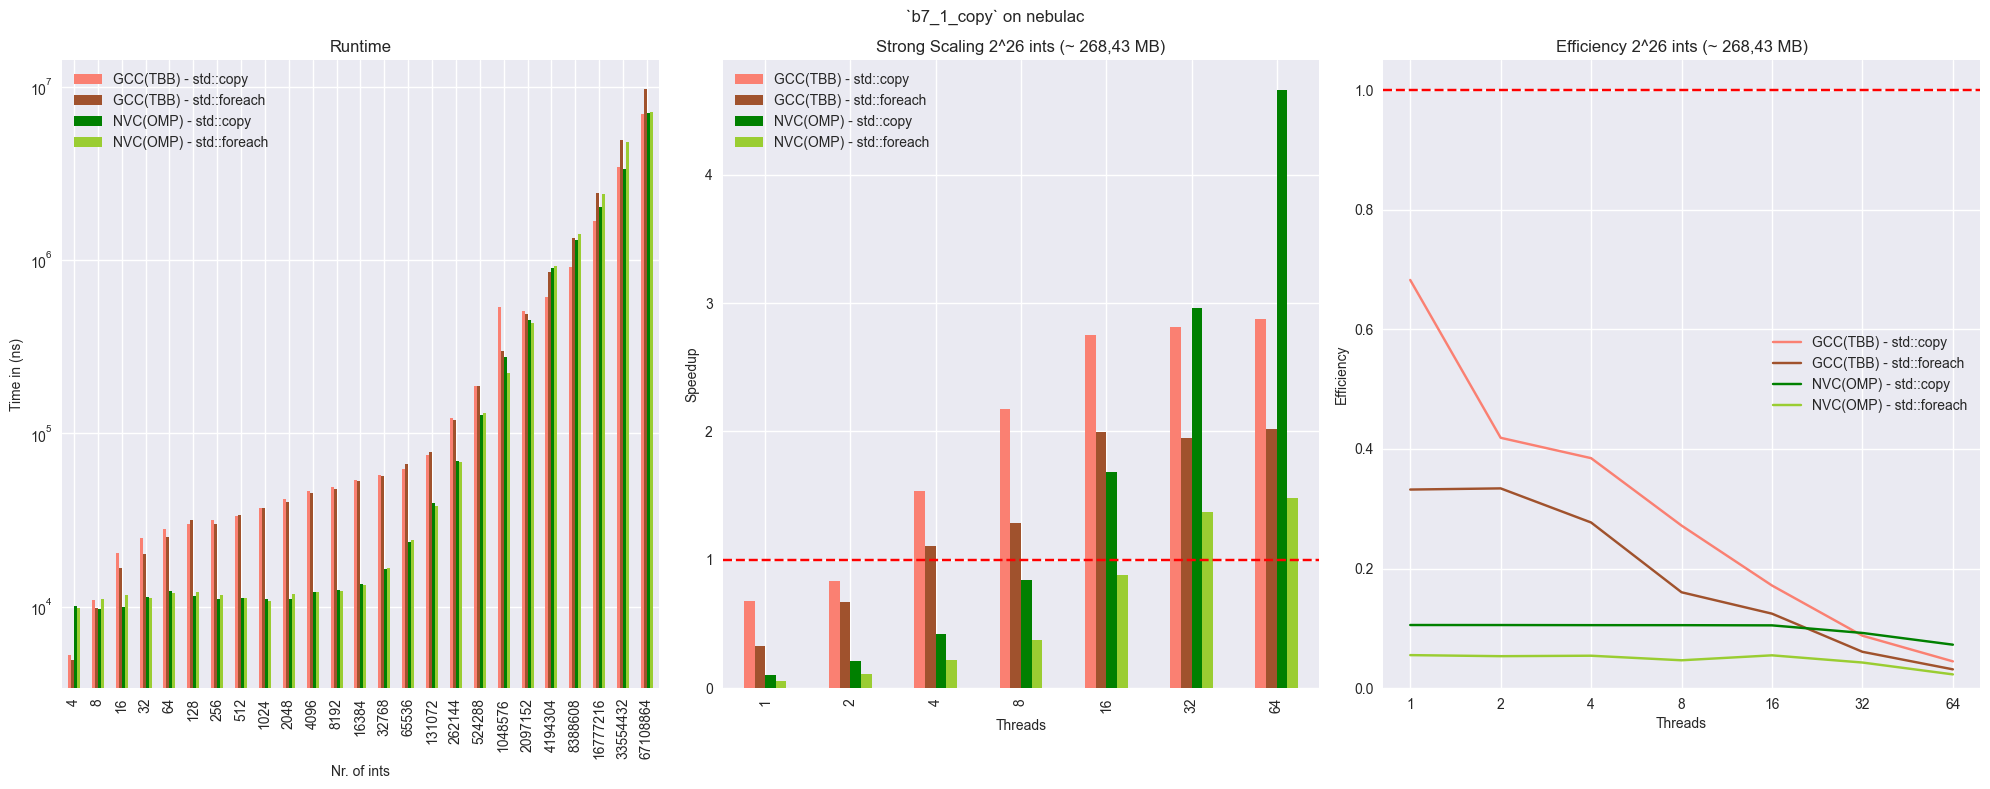

In [125]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_1_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_1_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,2.75)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b7_1_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_1_copy` on {device_name}")

fig.tight_layout()

plot(f"`b7_1_copy` {device_name}")

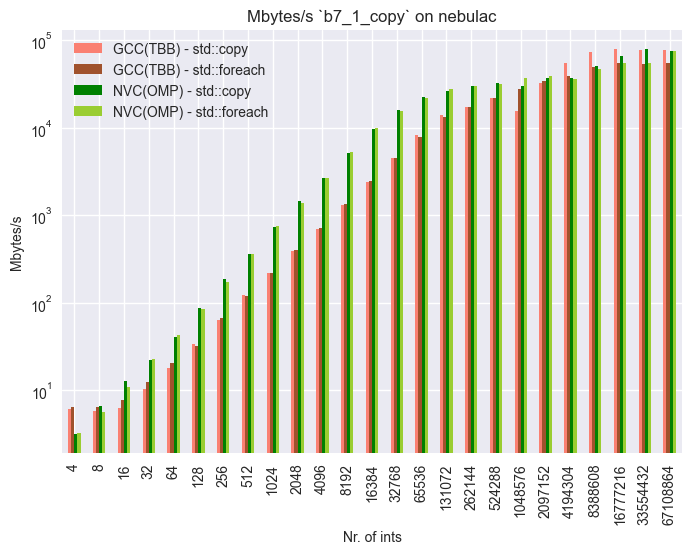

In [126]:
# mybtes graph


b7_1_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                    )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_1_copy` on {device_name}')


plot(f'`b7_1_copy` Mbytes_s on {device_name}')

## `b7_2` -  all_true

In [127]:
benchmark_names = [
    ("b7_2_all_of_all_true",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_all_true",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_all_true'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - all_true

Check how the runtime without constraining the threads develops with increasing input size

In [128]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_time_merged = pd.merge(b7_2_time_merged,data[i], on='n')

b7_2_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4749.02,4,1913.13,35945.1,22290.5
1,11863.90,8,5895.28,36495.9,22189.0
2,18080.00,16,10470.70,37358.3,22128.9
3,22571.90,32,15555.30,40405.0,22956.4
4,26373.60,64,20386.80,40611.5,24127.6
5,28740.70,128,23999.90,40536.9,24508.5
6,29786.10,256,26141.20,40840.8,24450.2
7,31876.20,512,28144.30,41322.0,24444.4
8,34483.20,1024,30790.90,41745.7,24479.1
9,38028.30,2048,33767.50,41778.9,24997.5


### Strong Scaling - all true
 
2^26 fixed input size with threads 1-64

In [129]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_strong_scaling_merged = pd.merge(b7_2_strong_scaling_merged,data[i], on='threads')


b7_2_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.050085,0.798598,0.337891,0.445527
1,2,1.914766,1.589737,0.662430,0.902663
2,4,2.944087,2.653818,1.244611,1.776443
3,8,4.114052,3.810341,1.665757,3.487695
4,16,5.691578,5.691834,1.688781,6.765676
5,32,6.339299,6.380546,1.668060,10.989363
6,64,6.845532,6.538658,1.484848,16.179062


In [130]:
## efficiency graph

b7_2_efficiency = b7_2_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_efficiency[f'{compiler_name} - {display_name}'] = b7_2_efficiency[f'{compiler_name} - {display_name}'] / b7_2_efficiency['threads']

b7_2_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.050085,0.798598,0.337891,0.445527
1,2,0.957383,0.794868,0.331215,0.451331
2,4,0.736022,0.663454,0.311153,0.444111
3,8,0.514257,0.476293,0.208220,0.435962
4,16,0.355724,0.355740,0.105549,0.422855
5,32,0.198103,0.199392,0.052127,0.343418
6,64,0.106961,0.102167,0.023201,0.252798


### Mbytes/s

In [131]:
# collect data for instances

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  benchmark_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_all_true_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_all_true_bytes_merged = pd.merge(b7_2_all_true_bytes_merged,data[i], on='n')

b7_2_all_true_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,3.36911,16.7265,0.445123,1.43559
1,8,2.69726,10.8561,0.876811,2.88431
2,16,3.53982,12.2245,1.713140,5.78430
3,32,5.67078,16.4574,3.167930,11.15160
4,64,9.70666,25.1143,6.303630,21.22050
5,128,17.81450,42.6669,12.630500,41.78130
6,256,34.37840,78.3438,25.072900,83.76210
7,512,64.24860,145.5360,49.561900,167.56400
8,1024,118.78200,266.0520,98.117800,334.65300
9,2048,215.41900,485.2000,196.080000,655.42500


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_12585/1266373404.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


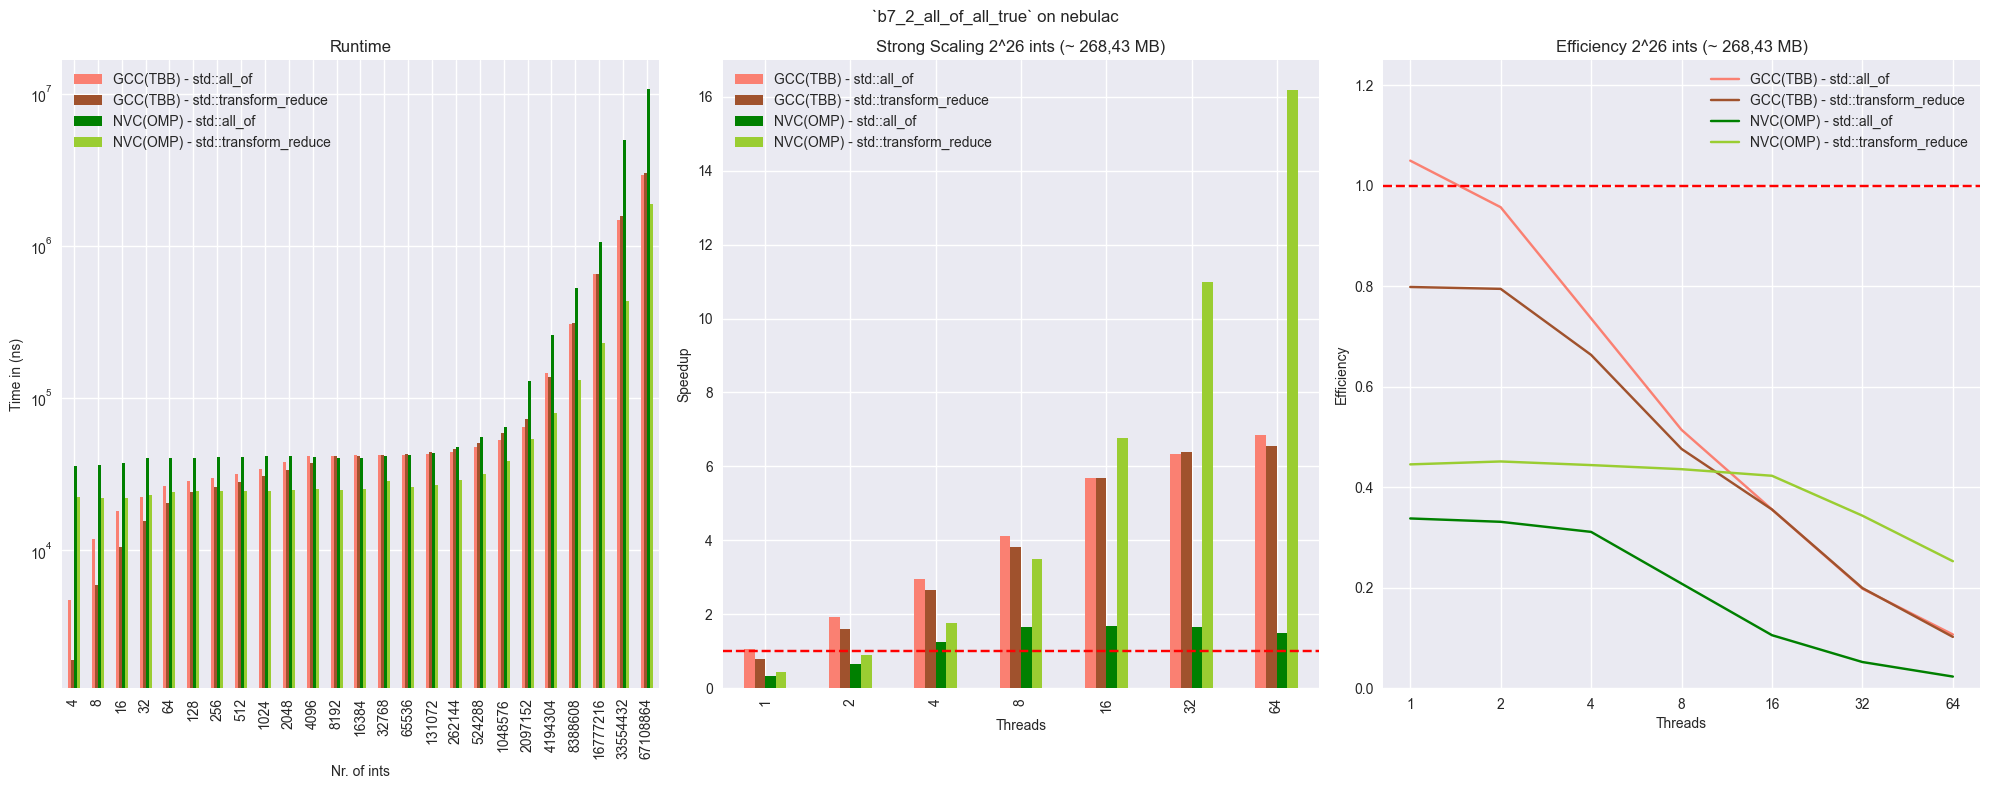

In [132]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
#ax_2.set_ylim(0,5)





# plot efficiency
ax_3 = b7_2_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_all_true` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_all_true` {device_name}")

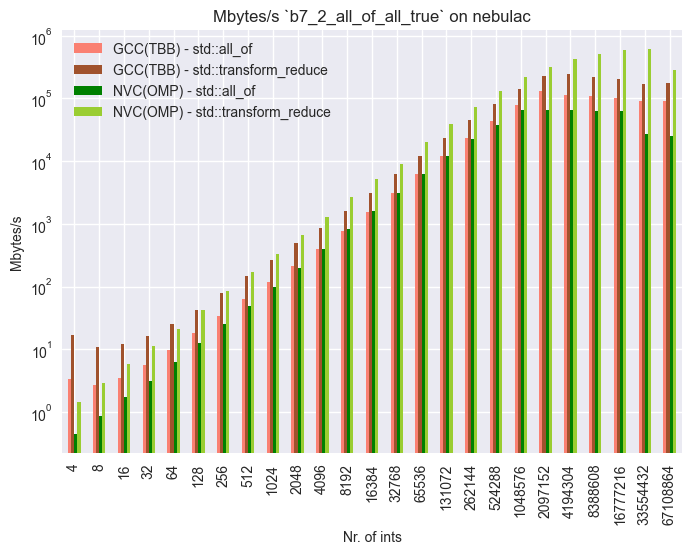

In [133]:
# mybtes graph


b7_2_all_true_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_all_true` on {device_name}')


plot(f'`b7_2_all_of_all_true` Mbytes_s on {device_name}')

## `b7_2` -  first_false

In [134]:
benchmark_names = [
    ("b7_2_all_of_first_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_first_false",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_first_false'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - first_false

Check how the runtime without constraining the threads develops with increasing input size

In [135]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_first_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_time_merged = pd.merge(b7_2_first_false_time_merged,data[i], on='n')

b7_2_first_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,5023.61,4,2951.49,43560.2,22104.8
1,8619.34,8,6003.54,44747.8,21060.9
2,11544.20,16,10738.70,45695.4,21588.0
3,14151.10,32,15924.60,49570.0,23354.9
4,16416.10,64,20478.90,49600.9,23697.4
5,18672.00,128,24075.30,46851.1,23693.4
6,20786.20,256,26091.50,46937.5,22734.1
7,20962.00,512,27540.60,49019.4,22871.8
8,21256.00,1024,30061.60,49125.2,23058.4
9,21572.20,2048,33374.60,49131.3,24802.8


### Strong Scaling - first_false
 
2^26 fixed input size with threads 1-64

In [136]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_first_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_strong_scaling_merged = pd.merge(b7_2_first_false_strong_scaling_merged,data[i], on='threads')


b7_2_first_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.045866,0.000001,0.000028,6.805967e-07
1,2,0.007199,0.000002,0.000055,1.361315e-06
2,4,0.002304,0.000004,0.000104,2.645227e-06
3,8,0.002002,0.000006,0.000179,5.110976e-06
4,16,0.001865,0.000009,0.000278,9.810443e-06
5,32,0.001365,0.000010,0.000367,1.609206e-05
6,64,0.001516,0.000010,0.000475,1.747785e-05


In [137]:
## efficiency graph

b7_2_first_false_efficiency = b7_2_first_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_first_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_first_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_first_false_efficiency['threads']

b7_2_first_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.045866,1.222793e-06,0.000028,6.805967e-07
1,2,0.003599,1.211670e-06,0.000027,6.806573e-07
2,4,0.000576,1.042740e-06,0.000026,6.613067e-07
3,8,0.000250,7.730780e-07,0.000022,6.388720e-07
4,16,0.000117,5.562499e-07,0.000017,6.131527e-07
5,32,0.000043,2.991446e-07,0.000011,5.028768e-07
6,64,0.000024,1.610355e-07,0.000007,2.730914e-07


### Mbytes/s

In [138]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_2_first_false_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_first_false_bytes_merged = pd.merge(b7_2_first_false_bytes_merged,data[i], on='n')

b7_2_first_false_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,3.184960e+00,10.8420,3.673080e-01,1.44765
1,8,3.712580e+00,10.6604,7.151180e-01,3.03880
2,16,5.543910e+00,11.9195,1.400580e+00,5.92921
3,32,9.045260e+00,16.0758,2.582210e+00,10.96130
4,64,1.559440e+01,25.0014,5.161200e+00,21.60570
5,128,2.742080e+01,42.5332,1.092820e+01,43.21880
6,256,4.926350e+01,78.4929,2.181630e+01,90.08500
7,512,9.770040e+01,148.7260,4.177940e+01,179.08500
8,1024,1.926980e+02,272.5070,8.337880e+01,355.27100
9,2048,3.797480e+02,490.9120,1.667370e+02,660.57100


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_12585/1392981099.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


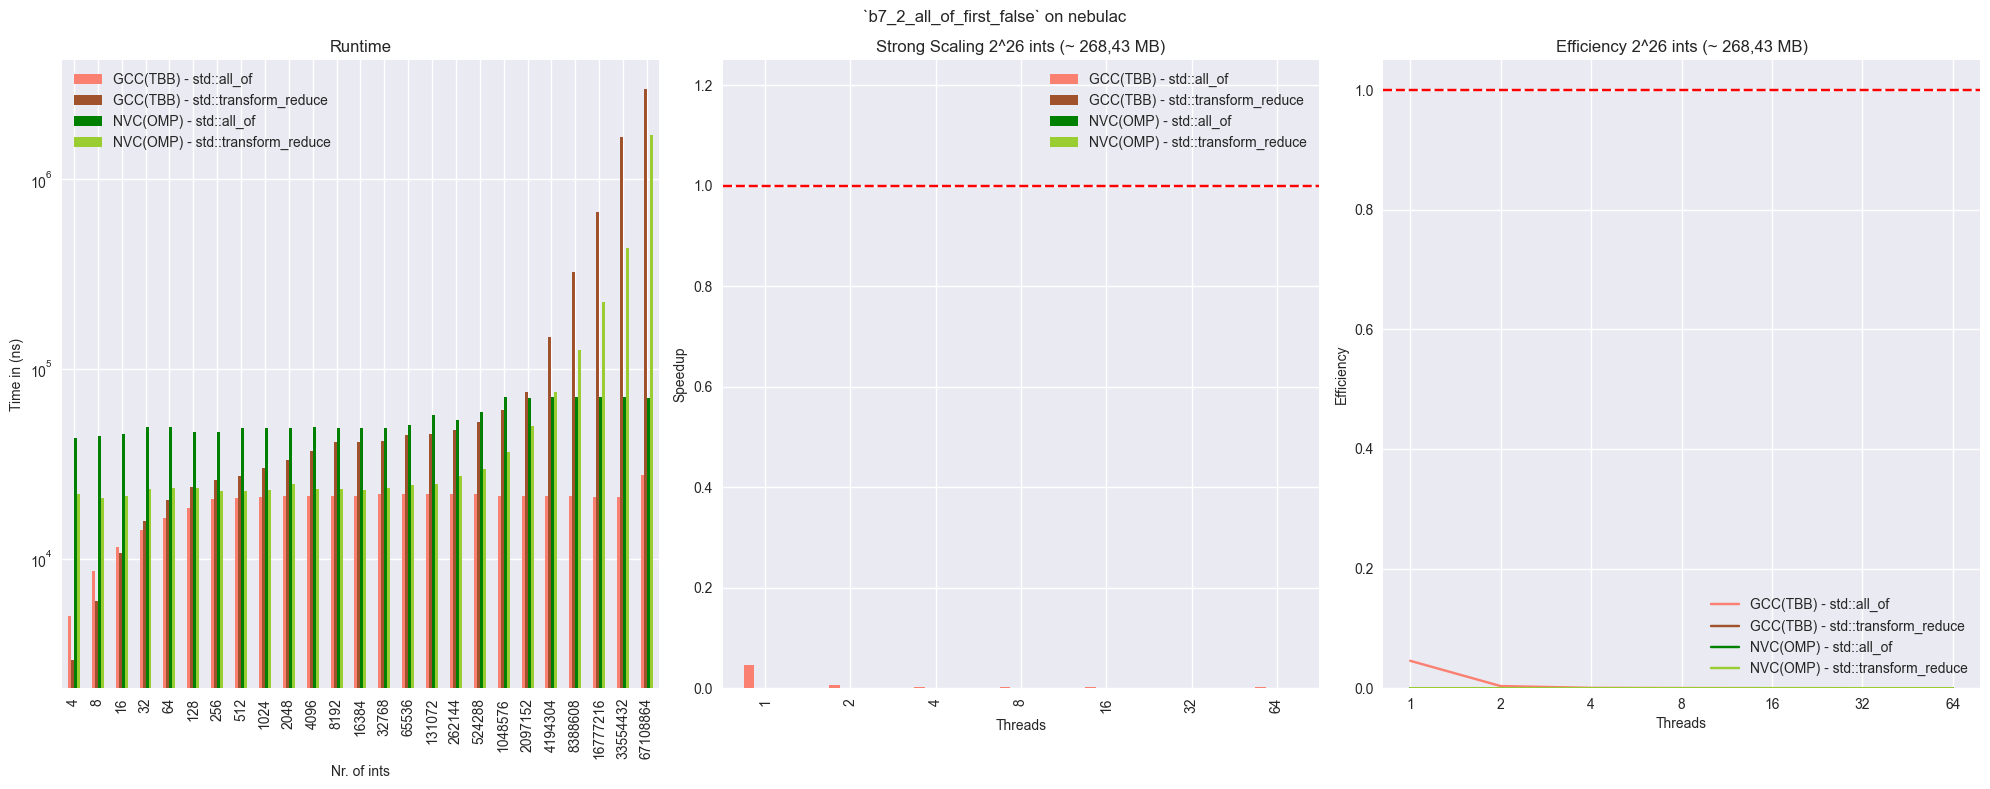

In [139]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_first_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_first_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
ax_2.set_ylim(0,1.25)





# plot efficiency
ax_3 = b7_2_first_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_first_false` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_first_false` {device_name}")

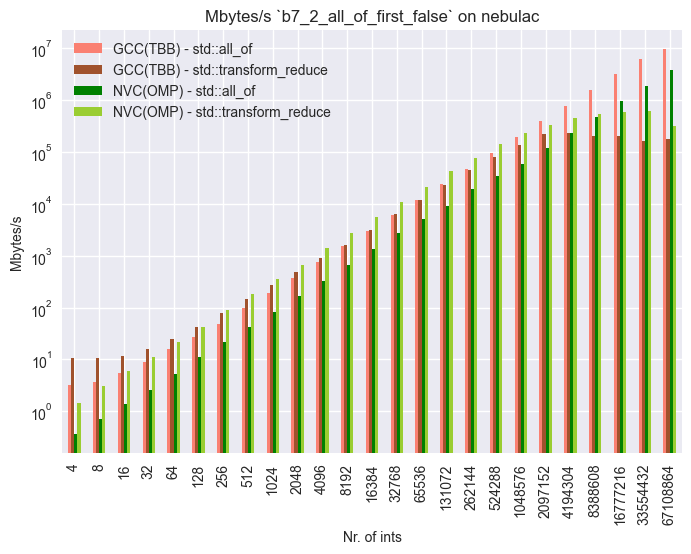

In [140]:

# mybtes graph


b7_2_first_false_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_first_false` on {device_name}')


plot(f'`b7_2_all_of_first_false` Mbytes_s on {device_name}')

## `b7_2` -  last_false

In [141]:
benchmark_names = [
    ("b7_2_all_of_last_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_last_false",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_last_false'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - last_false

Check how the runtime without constraining the threads develops with increasing input size

In [142]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_last_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_time_merged = pd.merge(b7_2_last_false_time_merged,data[i], on='n')

b7_2_last_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4563.73,4,2329.94,41740.4,23421.8
1,10266.00,8,6024.56,41782.2,23145.9
2,15533.80,16,11074.20,41454.4,23406.2
3,20056.60,32,16577.70,41958.8,26068.6
4,23041.50,64,21512.40,42641.6,26050.7
5,24953.50,128,28032.30,43056.0,25951.5
6,26158.60,256,31911.00,42742.2,25580.6
7,27640.90,512,29700.40,42750.0,25742.6
8,30086.90,1024,32364.10,42982.8,25431.2
9,32705.90,2048,35700.60,42936.0,25260.2


### Strong Scaling - last_false
 
2^26 fixed input size with threads 1-64

In [143]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_last_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_strong_scaling_merged = pd.merge(b7_2_last_false_strong_scaling_merged,data[i], on='threads')


b7_2_last_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.055423,0.736880,0.280871,0.441545
1,2,2.088103,1.490538,0.553703,0.886953
2,4,3.415300,2.735499,1.051429,1.764953
3,8,5.163180,4.311011,1.781147,3.497735
4,16,7.273102,6.401962,1.907074,6.897728
5,32,8.065674,7.034552,1.656939,11.256855
6,64,8.463261,7.377716,1.806088,20.698438


In [144]:
## efficiency graph

b7_2_last_false_efficiency = b7_2_last_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_last_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_last_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_last_false_efficiency['threads']

b7_2_last_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,1.055423,0.736880,0.280871,0.441545
1,2,1.044051,0.745269,0.276851,0.443476
2,4,0.853825,0.683875,0.262857,0.441238
3,8,0.645398,0.538876,0.222643,0.437217
4,16,0.454569,0.400123,0.119192,0.431108
5,32,0.252052,0.219830,0.051779,0.351777
6,64,0.132238,0.115277,0.028220,0.323413


### Mbytes/s

In [145]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_2_last_false_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_last_false_bytes_merged = pd.merge(b7_2_last_false_bytes_merged,data[i], on='n')

b7_2_last_false_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,3.50590,13.7343,0.383321,1.36625
1,8,3.11710,10.6232,0.765876,2.76507
2,16,4.12005,11.5584,1.543860,5.46863
3,32,6.38194,15.4424,3.050610,9.82023
4,64,11.11040,23.8002,6.003530,19.65400
5,128,20.51820,36.5293,11.891500,39.45820
6,256,39.14580,64.1785,23.957600,80.06080
7,512,74.09300,137.9110,47.906400,159.11400
8,1024,136.13900,253.1200,95.293900,322.12400
9,2048,250.47500,458.9280,190.796000,648.60900


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_12585/3850368593.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


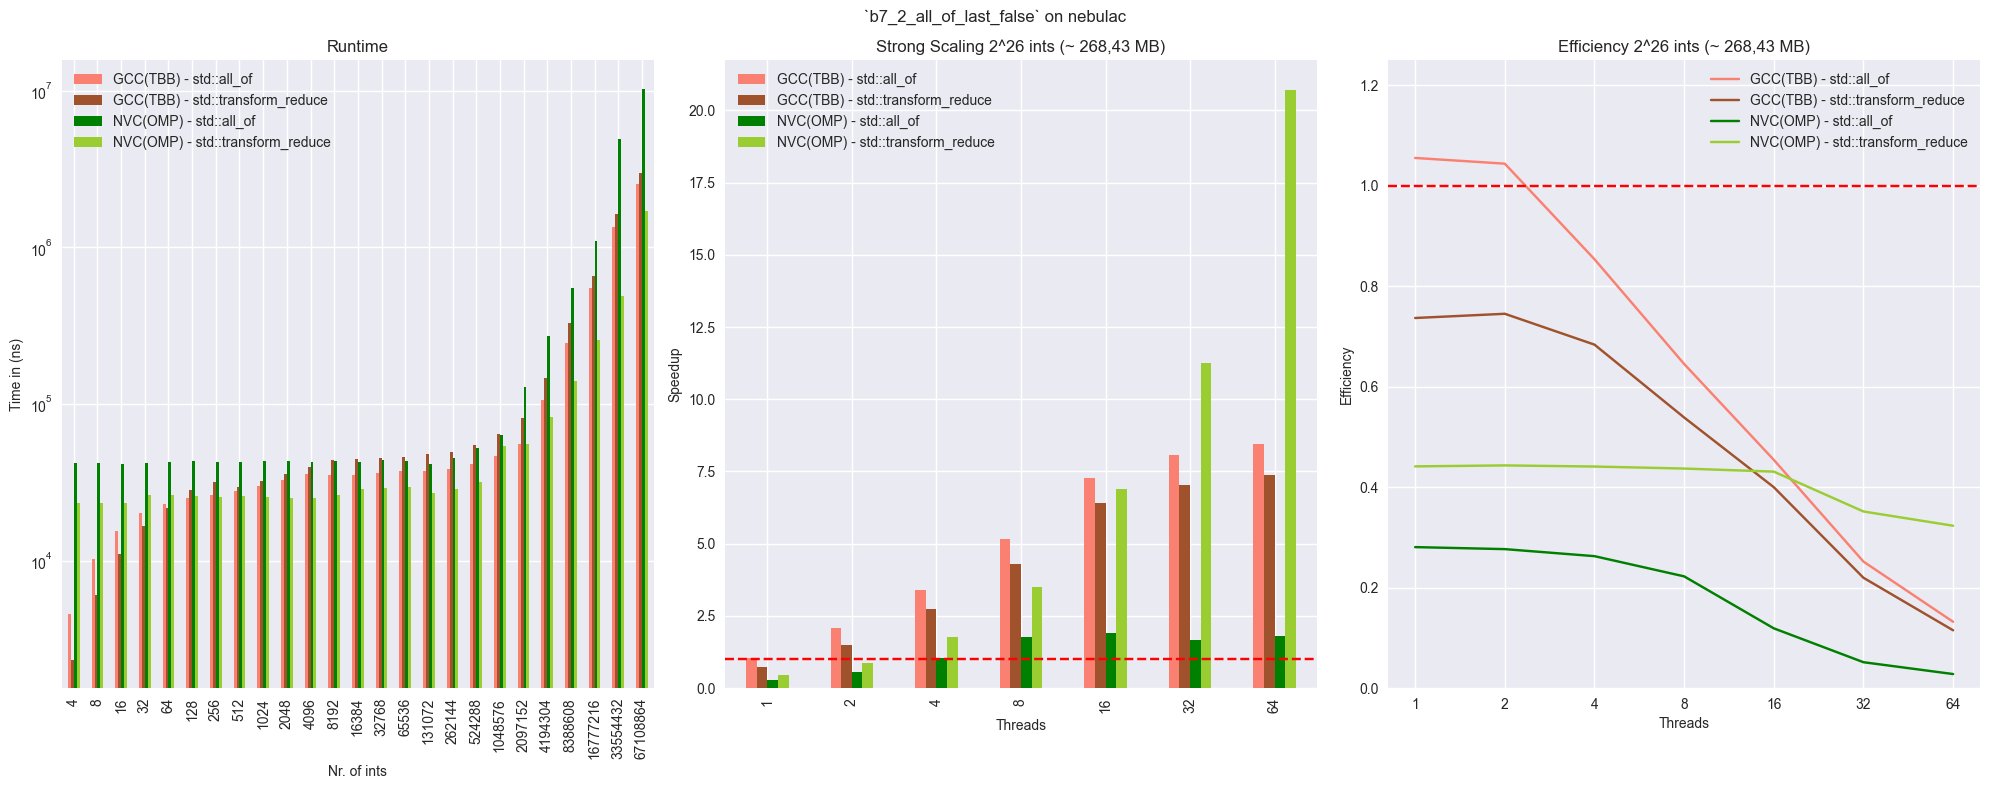

In [146]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_last_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_last_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')
#ax_2.set_ylim(0,5)





# plot efficiency
ax_3 = b7_2_last_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_last_false` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_last_false` {device_name}")

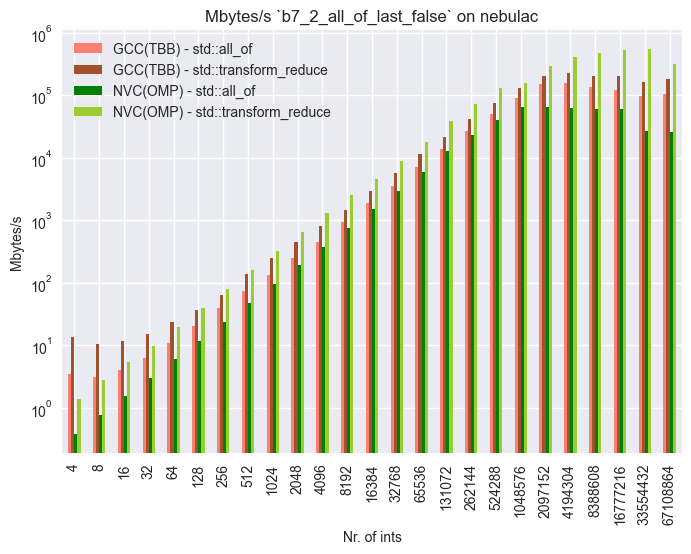

In [147]:
b7_2_last_false_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_last_false` on {device_name}')


plot(f'`b7_2_all_of_last_false` Mbytes_s on {device_name}')

## `b7_2` -  auto_false

In [148]:
benchmark_names = [
    ("b7_2_all_of_auto_false",'std::all_of'),
    ("b7_2_custom_all_of_with_transform_reduce_auto_false",'std::transform_reduce')
]

strong_scale_base = 'b7_2_all_of_auto_false'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - auto_false

Check how the runtime without constraining the threads develops with increasing input size

In [149]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_2_auto_false_time_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_time_merged = pd.merge(b7_2_auto_false_time_merged,data[i], on='n')

b7_2_auto_false_time_merged

,GCC(TBB) - std::all_of,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,7145.61,4,2383.13,49288.5,22383.0
1,11140.20,8,5426.17,49662.8,22220.3
2,14308.40,16,10370.30,49479.1,22242.9
3,17443.80,32,20102.90,49099.2,24896.0
4,19886.20,64,20911.90,50491.7,25602.4
5,22527.20,128,24453.50,51281.6,25993.5
6,24987.50,256,26391.70,51179.9,26019.6
7,25124.90,512,28086.30,51190.2,26138.1
8,19086.00,1024,30549.10,51112.2,26174.7
9,19011.40,2048,35376.50,51170.4,26315.7


### Strong Scaling - auto_false
 
2^26 fixed input size with threads 1-64

In [150]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_2_auto_false_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_strong_scaling_merged = pd.merge(b7_2_auto_false_strong_scaling_merged,data[i], on='threads')


b7_2_auto_false_strong_scaling_merged

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.043888,0.000005,0.000121,0.041310
1,2,0.009979,0.000010,0.000225,0.007044
2,4,0.003255,0.000020,0.000379,0.003504
3,8,0.002062,0.000038,0.000496,0.002020
4,16,0.002170,0.000068,0.000554,0.001542
5,32,0.001838,0.000108,0.000626,0.001434
6,64,0.001622,0.000166,0.000605,0.001267


In [151]:
## efficiency graph

b7_2_auto_false_efficiency = b7_2_auto_false_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_2_auto_false_efficiency[f'{compiler_name} - {display_name}'] = b7_2_auto_false_efficiency[f'{compiler_name} - {display_name}'] / b7_2_auto_false_efficiency['threads']

b7_2_auto_false_efficiency

,threads,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,1,0.043888,0.000005,0.000121,0.041310
1,2,0.004989,0.000005,0.000112,0.003522
2,4,0.000814,0.000005,0.000095,0.000876
3,8,0.000258,0.000005,0.000062,0.000252
4,16,0.000136,0.000004,0.000035,0.000096
5,32,0.000057,0.000003,0.000020,0.000045
6,64,0.000025,0.000003,0.000009,0.000020


### Mbytes/s

In [152]:
# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_2_auto_false_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_2_auto_false_bytes_merged = pd.merge(b7_2_auto_false_bytes_merged,data[i], on='n')

b7_2_auto_false_bytes_merged

,n,GCC(TBB) - std::all_of,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::all_of,NVC(OMP) - std::transform_reduce
0,4,2.239140e+00,1.342770e+01,3.246190e-01,1.429660e+00
1,8,2.872480e+00,1.179470e+01,6.443460e-01,2.880250e+00
2,16,4.472910e+00,1.234290e+01,1.293480e+00,5.754650e+00
3,32,7.337840e+00,1.273450e+01,2.606970e+00,1.028280e+01
4,64,1.287320e+01,2.448370e+01,5.070140e+00,1.999810e+01
5,128,2.272800e+01,4.187540e+01,9.984080e+00,3.939450e+01
6,256,4.098050e+01,7.760010e+01,2.000780e+01,7.870990e+01
7,512,8.151270e+01,1.458360e+02,4.000770e+01,1.567060e+02
8,1024,2.146070e+02,2.681580e+02,8.013740e+01,3.129740e+02
9,2048,4.308980e+02,4.631320e+02,1.600930e+02,6.225940e+02


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_12585/1629545763.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


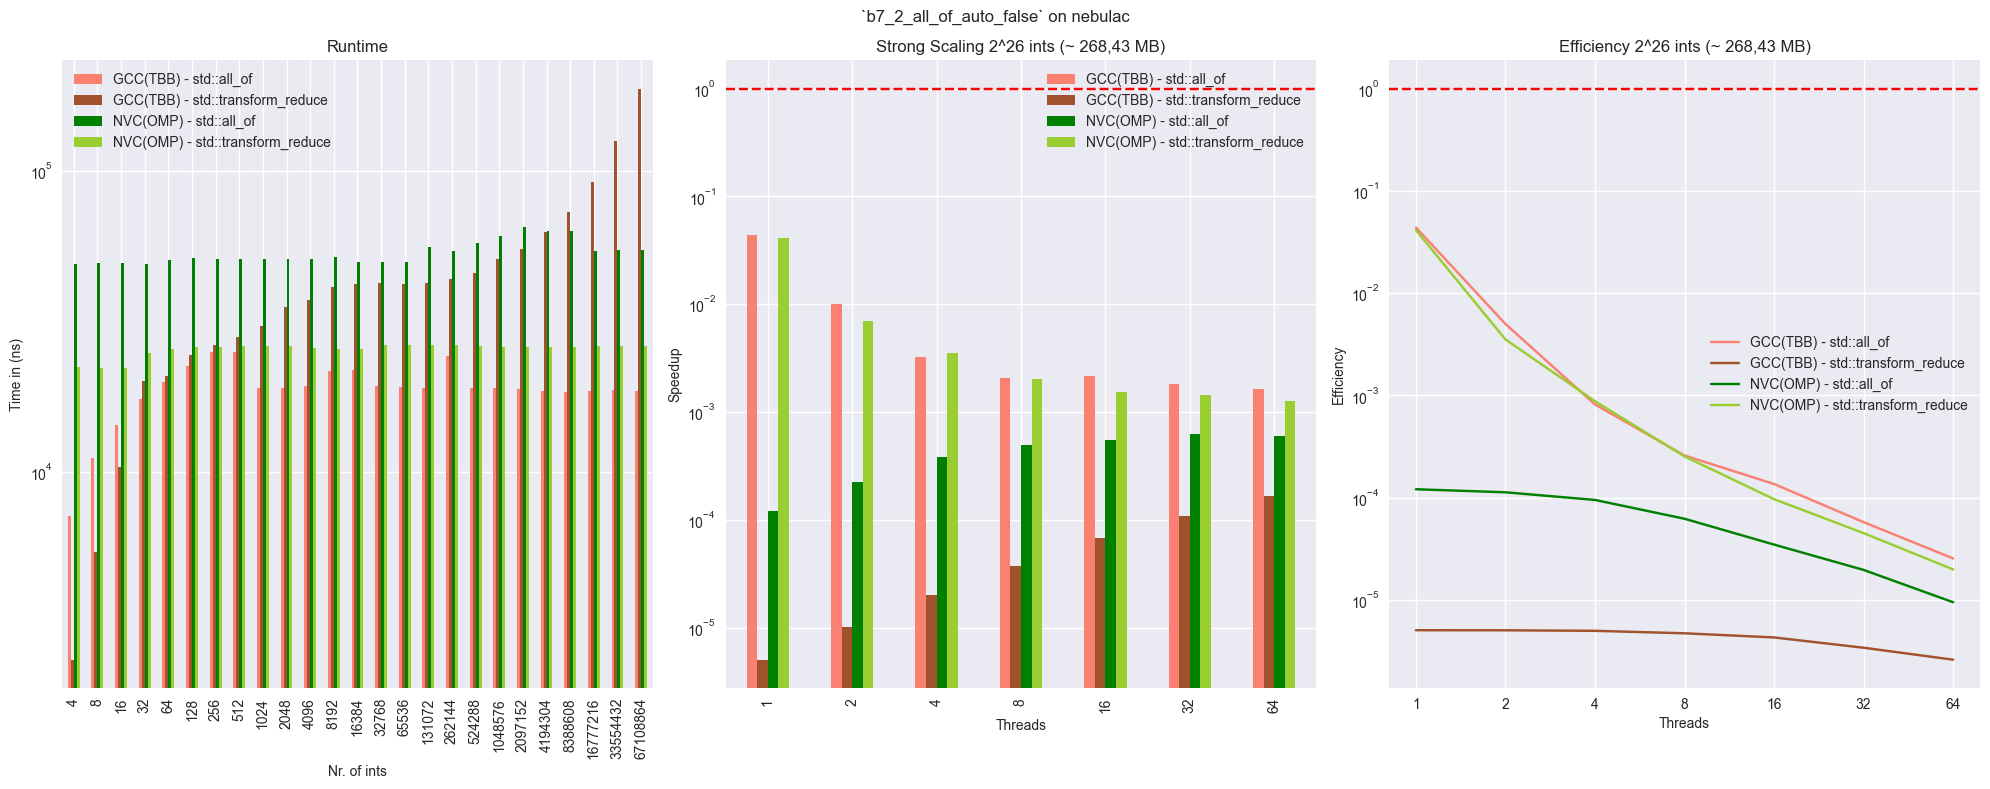

In [153]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_2_auto_false_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_2_auto_false_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_yscale('log',base=10)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')



# plot efficiency
ax_3 = b7_2_auto_false_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_yscale('log',base=10)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_2_all_of_auto_false` on {device_name}")

fig.tight_layout()

plot(f"`b7_2_all_of_auto_false` {device_name}")

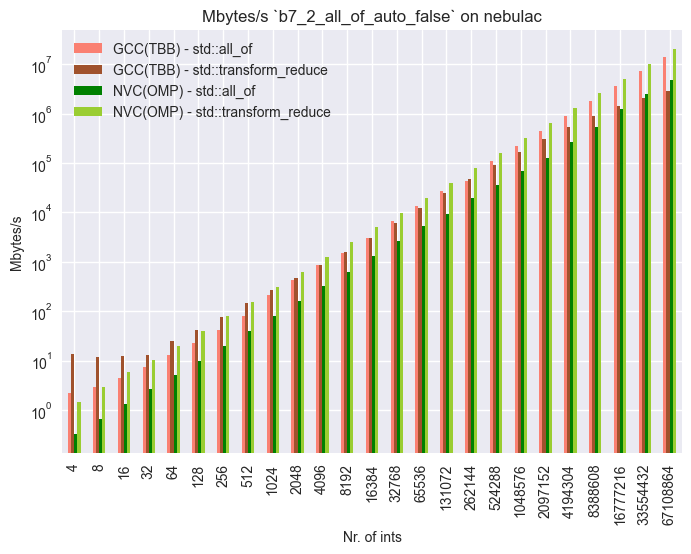

In [154]:

# mybtes graph

b7_2_auto_false_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_2_all_of_auto_false` on {device_name}')


plot(f'`b7_2_all_of_auto_false` Mbytes_s on {device_name}')

## `b7_3` -  all_hit

In [155]:
benchmark_names = [
    ("b7_3_count_if_all_hit",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_all_hit",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_all_hit",'std::for_each')
]

strong_scale_base = 'b7_3_count_if_all_hit'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - all_hit

Check how the runtime without constraining the threads develops with increasing input size

In [156]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_all_hit_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_time_merged = pd.merge(b7_3_all_hit_time_merged,data[i], on='n')

b7_3_all_hit_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,5191.48,4,2089.00,21824.1,20244.3
1,9855.71,8,7480.05,23685.4,20562.5
2,15144.50,16,13260.60,23960.6,21976.6
3,20188.90,32,18769.40,24612.0,22467.6
4,24166.30,64,23538.10,25005.1,23807.8
5,26202.10,128,27082.30,23286.2,23278.9
6,28294.40,256,29634.10,25105.4,23376.1
7,31350.30,512,30719.40,23102.7,23347.3
8,35140.20,1024,32279.40,23136.6,24672.5
9,38786.50,2048,34885.50,25027.8,23769.3


### Strong Scaling - all_hit
 
2^26 fixed input size with threads 1-64

In [157]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_all_hit_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_strong_scaling_merged = pd.merge(b7_3_all_hit_strong_scaling_merged,data[i], on='threads')


b7_3_all_hit_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.016581,0.575181,0.937756,1.403220
1,2,1.954820,1.162637,1.867705,2.216550
2,4,2.836698,2.094740,3.721416,5.538230
3,8,3.385467,3.452492,6.176876,8.615839
4,16,5.085579,5.153164,11.858919,15.636037
5,32,5.779347,5.660958,14.587219,14.102747
6,64,5.805186,6.040727,9.252597,8.206982


In [158]:
## efficiency graph

b7_3_all_hit_efficiency = b7_3_all_hit_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_all_hit_efficiency[f'{compiler_name} - {display_name}'] = b7_3_all_hit_efficiency[f'{compiler_name} - {display_name}'] / b7_3_all_hit_efficiency['threads']

b7_3_all_hit_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.016581,0.575181,0.937756,1.403220
1,2,0.977410,0.581319,0.933853,1.108275
2,4,0.709175,0.523685,0.930354,1.384558
3,8,0.423183,0.431561,0.772110,1.076980
4,16,0.317849,0.322073,0.741182,0.977252
5,32,0.180605,0.176905,0.455851,0.440711
6,64,0.090706,0.094386,0.144572,0.128234


### Mbytes/s

In [159]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_3_all_hit_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_3_all_hit_bytes_merged = pd.merge(b7_3_all_hit_bytes_merged,data[i], on='n')

b7_3_all_hit_bytes_merged

,n,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4,3.08197,7.65915,0.733135,7.903450e-01
1,8,3.24685,4.27805,1.351040,1.556230e+00
2,16,4.22594,4.82632,2.671050,2.912190e+00
3,32,6.34011,6.81960,5.200710,5.697100e+00
4,64,10.59330,10.87600,10.237900,1.075280e+01
5,128,19.54040,18.90540,21.987300,2.199420e+01
6,256,36.19100,34.55480,40.788000,4.380540e+01
7,512,65.32640,66.66790,88.647800,8.771900e+01
8,1024,116.56200,126.89200,177.035000,1.660150e+02
9,2048,211.20700,234.82600,327.317000,3.446460e+02


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_12585/3164471847.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


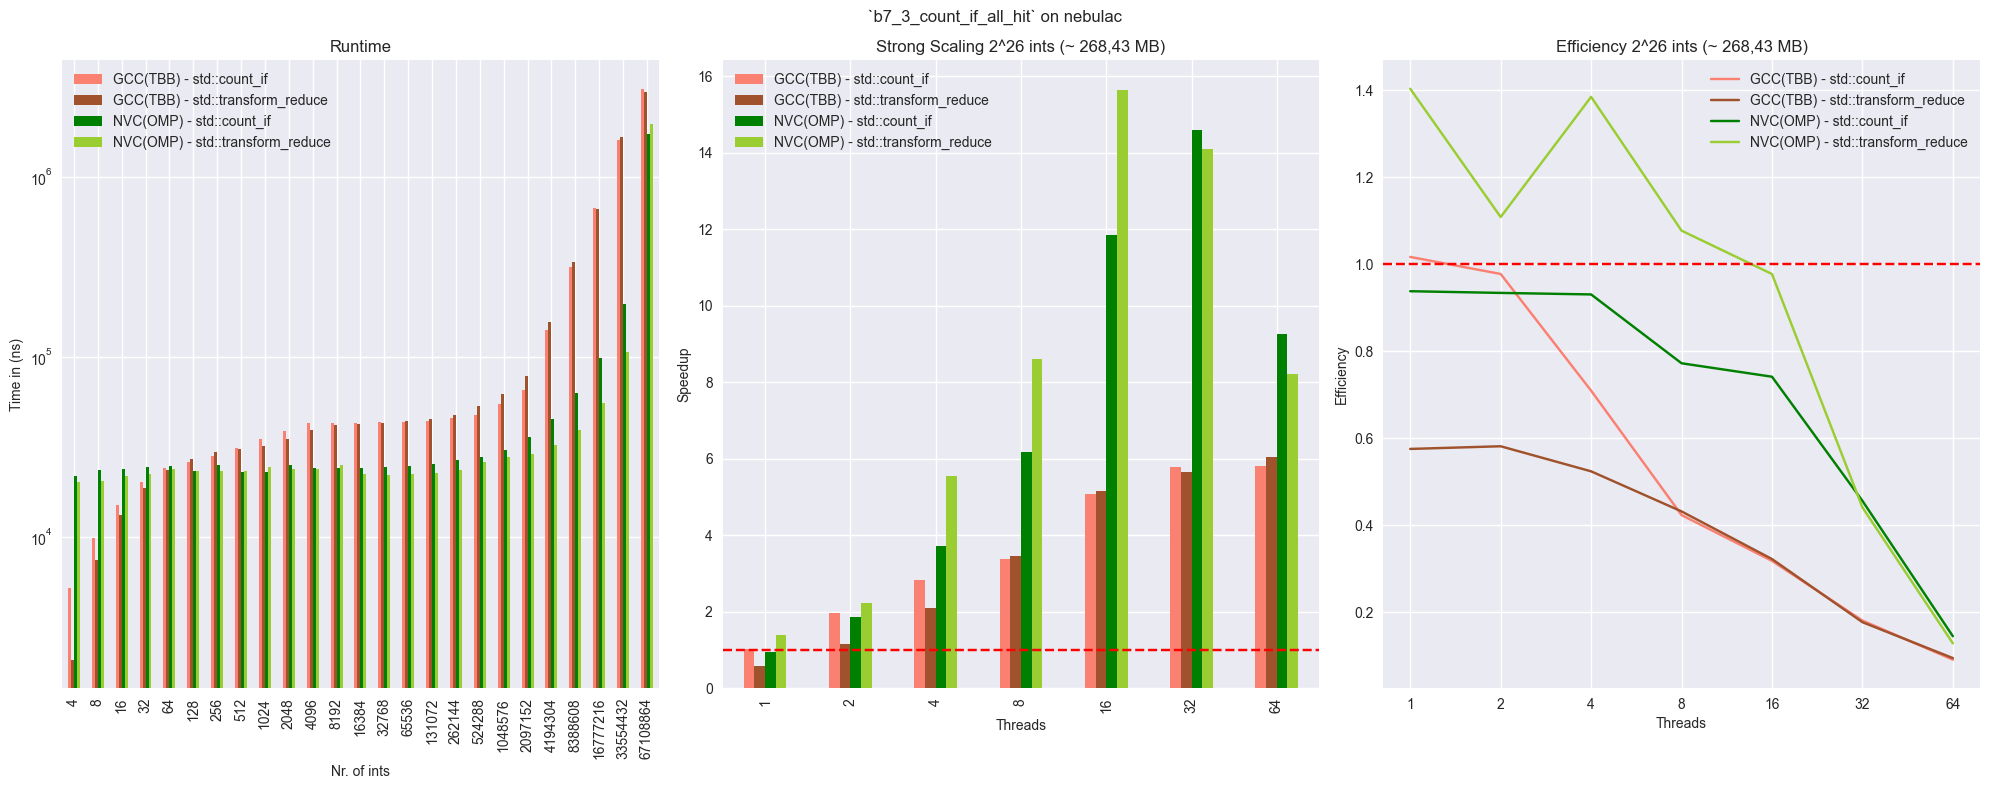

In [160]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_all_hit_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_all_hit_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_3_all_hit_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')

fig.suptitle(f"`b7_3_count_if_all_hit` on {device_name}")

fig.tight_layout()

plot(f"`b7_3_count_if_all_hit` {device_name}")

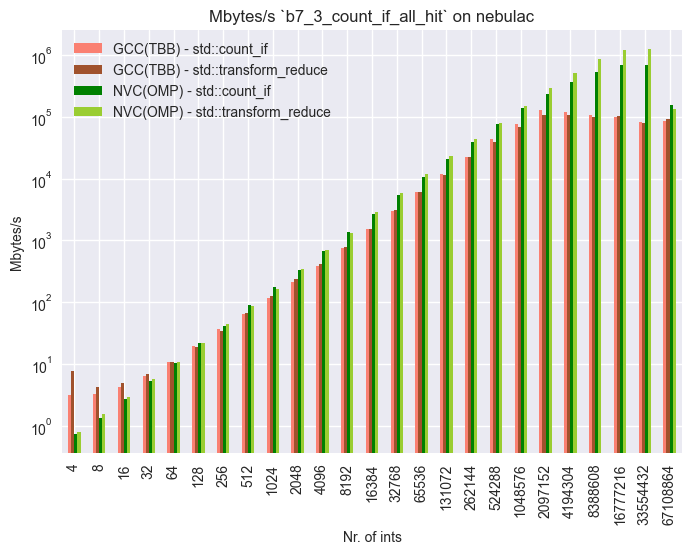

In [161]:
# mybtes graph

b7_3_all_hit_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_3_count_if_all_hit` on {device_name}')


plot(f'`b7_3_count_if_all_hit` Mbytes_s on {device_name}')

## `b7_3` -  half_hit

In [162]:
benchmark_names = [
    ("b7_3_count_if_half_hit",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_half_hit",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_half_hit",'std::for_each')
]

strong_scale_base = 'b7_3_count_if_half_hit'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - half_hit

Check how the runtime without constraining the threads develops with increasing input size

In [163]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_half_hit_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_time_merged = pd.merge(b7_3_half_hit_time_merged,data[i], on='n')

b7_3_half_hit_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,5487.42,4,2282.52,21181.6,24188.4
1,13584.80,8,7352.93,21155.0,23550.9
2,18760.50,16,13231.50,21149.9,23919.5
3,21651.40,32,19123.50,21941.4,24316.1
4,26404.20,64,23812.30,22275.7,24496.2
5,27952.20,128,27385.50,22323.2,23872.9
6,30298.60,256,28382.00,22351.1,23091.6
7,33809.60,512,27485.50,22561.0,23062.9
8,37637.30,1024,30114.60,23490.7,24670.6
9,41463.50,2048,33421.20,22360.5,24784.2


### Strong Scaling - half_hit
 
2^26 fixed input size with threads 1-64

In [164]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_half_hit_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_strong_scaling_merged = pd.merge(b7_3_half_hit_strong_scaling_merged,data[i], on='threads')


b7_3_half_hit_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.003344,0.566295,0.877475,1.294009
1,2,1.932701,1.143645,1.743008,2.569615
2,4,2.728645,2.167226,3.458748,5.096291
3,8,4.115485,3.495503,6.497362,7.967224
4,16,5.100652,4.983487,9.757602,11.974231
5,32,5.621878,5.535228,14.815766,13.568621
6,64,5.872867,5.709095,12.633178,10.145478


In [165]:
## efficiency graph

b7_3_half_hit_efficiency = b7_3_half_hit_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_half_hit_efficiency[f'{compiler_name} - {display_name}'] = b7_3_half_hit_efficiency[f'{compiler_name} - {display_name}'] / b7_3_half_hit_efficiency['threads']

b7_3_half_hit_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,1.003344,0.566295,0.877475,1.294009
1,2,0.966350,0.571822,0.871504,1.284807
2,4,0.682161,0.541806,0.864687,1.274073
3,8,0.514436,0.436938,0.812170,0.995903
4,16,0.318791,0.311468,0.609850,0.748389
5,32,0.175684,0.172976,0.462993,0.424019
6,64,0.091764,0.089205,0.197393,0.158523


### Mybtes/s

In [166]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_3_half_hit_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_3_half_hit_bytes_merged = pd.merge(b7_3_half_hit_bytes_merged,data[i], on='n')

b7_3_half_hit_bytes_merged


,n,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4,2.91576,7.00979,0.755374,6.614730e-01
1,8,2.35557,4.35201,1.512640,1.358760e+00
2,16,3.41142,4.83696,3.026020,2.675640e+00
3,32,5.91186,6.69332,5.833720,5.264000e+00
4,64,9.69543,10.75080,11.492300,1.045060e+01
5,128,18.31700,18.69600,22.935800,2.144690e+01
6,256,33.79690,36.07920,45.814300,4.434510e+01
7,512,60.57450,74.51190,90.776000,8.880050e+01
8,1024,108.82800,136.01400,174.367000,1.660280e+02
9,2048,197.57100,245.11400,366.361000,3.305330e+02


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_12585/4180608575.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


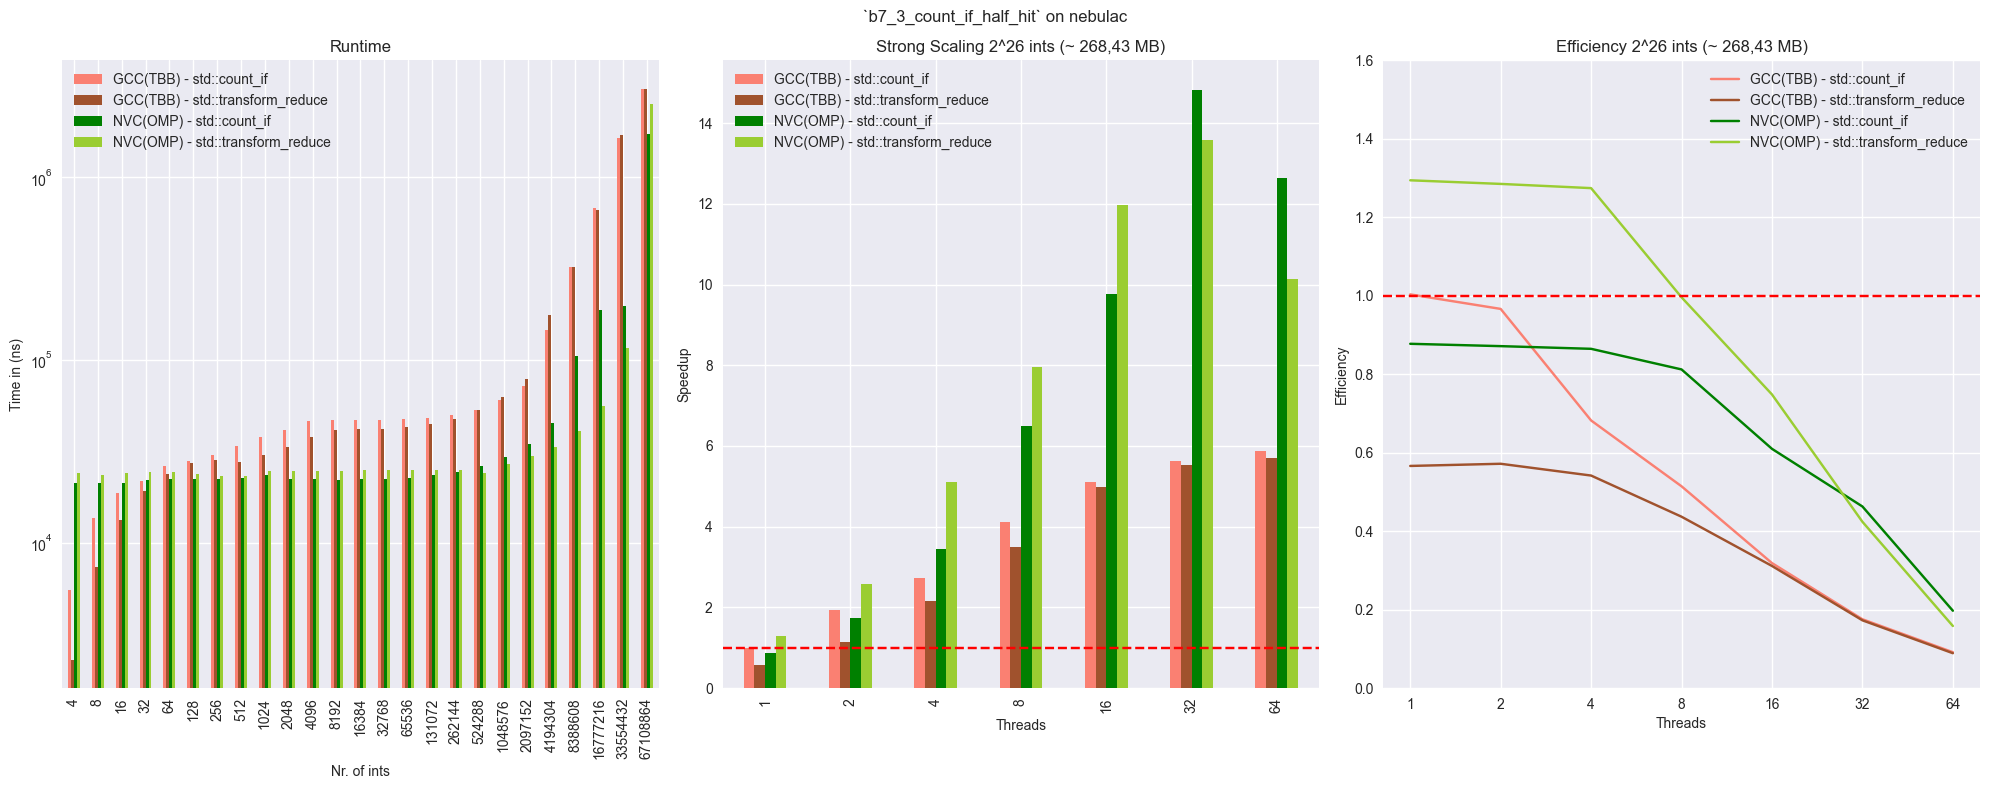

In [167]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_half_hit_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_half_hit_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_3_half_hit_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')
ax_3.set_ylim(0,1.6)


fig.suptitle(f"`b7_3_count_if_half_hit` on {device_name}")

fig.tight_layout()

plot(f"`b7_3_count_if_half_hit` {device_name}")

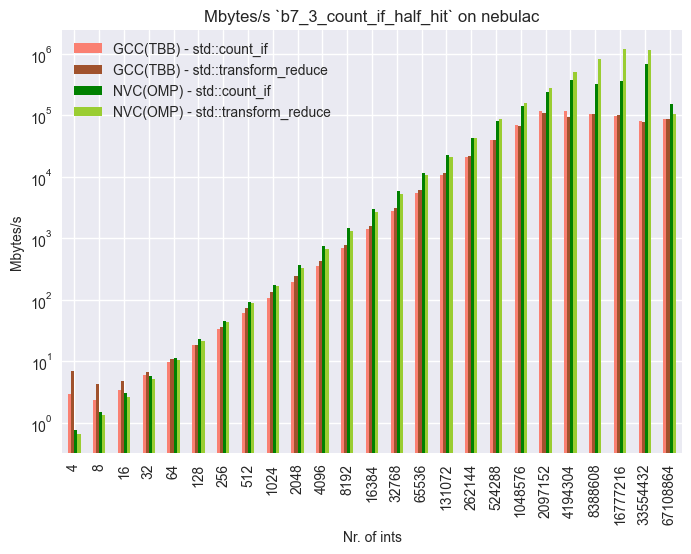

In [168]:
# mybtes graph

b7_3_half_hit_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_3_count_if_half_hit` on {device_name}')


plot(f'`b7_3_count_if_half_hit` Mbytes_s on {device_name}')

## `b7_3` -  orders_struct

In [169]:
benchmark_names = [
    ("b7_3_count_if_orders_struct",'std::count_if'),
    ("b7_3_custom_count_if_with_transform_reduce_orders_struct",'std::transform_reduce'),
    #("b7_3_custom_count_if_with_for_each_orders_struct",'std::for_each')
]

strong_scale_base = 'b7_3_count_if_orders_struct'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - orders_struct

Check how the runtime without constraining the threads develops with increasing input size

In [170]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_3_orders_struct_time_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_time_merged = pd.merge(b7_3_orders_struct_time_merged,data[i], on='n')

b7_3_orders_struct_time_merged

,GCC(TBB) - std::count_if,n,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4721.44,4,1941.04,23258.8,18665.6
1,14216.80,8,7177.96,23117.5,19696.9
2,20793.80,16,13267.50,23045.2,19717.9
3,25431.80,32,19003.30,23921.0,21384.4
4,26936.30,64,24001.00,24058.2,21211.9
5,28027.50,128,27760.20,24089.4,21416.8
6,30119.50,256,30029.20,23783.3,23199.4
7,32690.10,512,30923.70,23753.3,22860.4
8,37305.20,1024,32612.90,23904.1,21859.4
9,39595.60,2048,35106.50,23248.1,22427.3


### Strong Scaling - orders_struct
 
2^26 fixed input size with threads 1-64

In [171]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_3_orders_struct_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_strong_scaling_merged = pd.merge(b7_3_orders_struct_strong_scaling_merged,data[i], on='threads')


b7_3_orders_struct_strong_scaling_merged

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,0.991764,0.648057,0.950957,0.995759
1,2,1.953316,1.294810,1.899936,1.969771
2,4,2.643713,2.178831,3.772857,3.919822
3,8,3.438588,3.195149,7.009637,7.329406
4,16,4.622187,4.541131,12.909799,13.885463
5,32,5.011129,5.124417,16.956606,14.518549
6,64,5.336405,5.431416,16.051887,14.517854


In [172]:
## efficiency graph

b7_3_orders_struct_efficiency = b7_3_orders_struct_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_3_orders_struct_efficiency[f'{compiler_name} - {display_name}'] = b7_3_orders_struct_efficiency[f'{compiler_name} - {display_name}'] / b7_3_orders_struct_efficiency['threads']

b7_3_orders_struct_efficiency

,threads,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,1,0.991764,0.648057,0.950957,0.995759
1,2,0.976658,0.647405,0.949968,0.984886
2,4,0.660928,0.544708,0.943214,0.979956
3,8,0.429823,0.399394,0.876205,0.916176
4,16,0.288887,0.283821,0.806862,0.867841
5,32,0.156598,0.160138,0.529894,0.453705
6,64,0.083381,0.084866,0.250811,0.226841


### Mbytes/s

In [173]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_3_orders_struct_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_3_orders_struct_bytes_merged = pd.merge(b7_3_orders_struct_bytes_merged,data[i], on='n')

b7_3_orders_struct_bytes_merged

,n,GCC(TBB) - std::count_if,GCC(TBB) - std::transform_reduce,NVC(OMP) - std::count_if,NVC(OMP) - std::transform_reduce
0,4,6.77759,16.48600,1.37582,1.714380e+00
1,8,4.50173,8.91619,2.76847,3.249240e+00
2,16,6.15567,9.64766,5.55431,6.491560e+00
3,32,10.06620,13.47140,10.70190,1.197130e+01
4,64,19.00780,21.33250,21.28170,2.413740e+01
5,128,36.53550,36.88740,42.50830,4.781290e+01
6,256,67.99590,68.20030,86.11080,8.827820e+01
7,512,125.29800,132.45500,172.43900,1.791740e+02
8,1024,219.59400,251.18900,342.70200,3.747590e+02
9,2048,413.78300,466.69500,704.74700,7.305380e+02


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_12585/2492568009.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


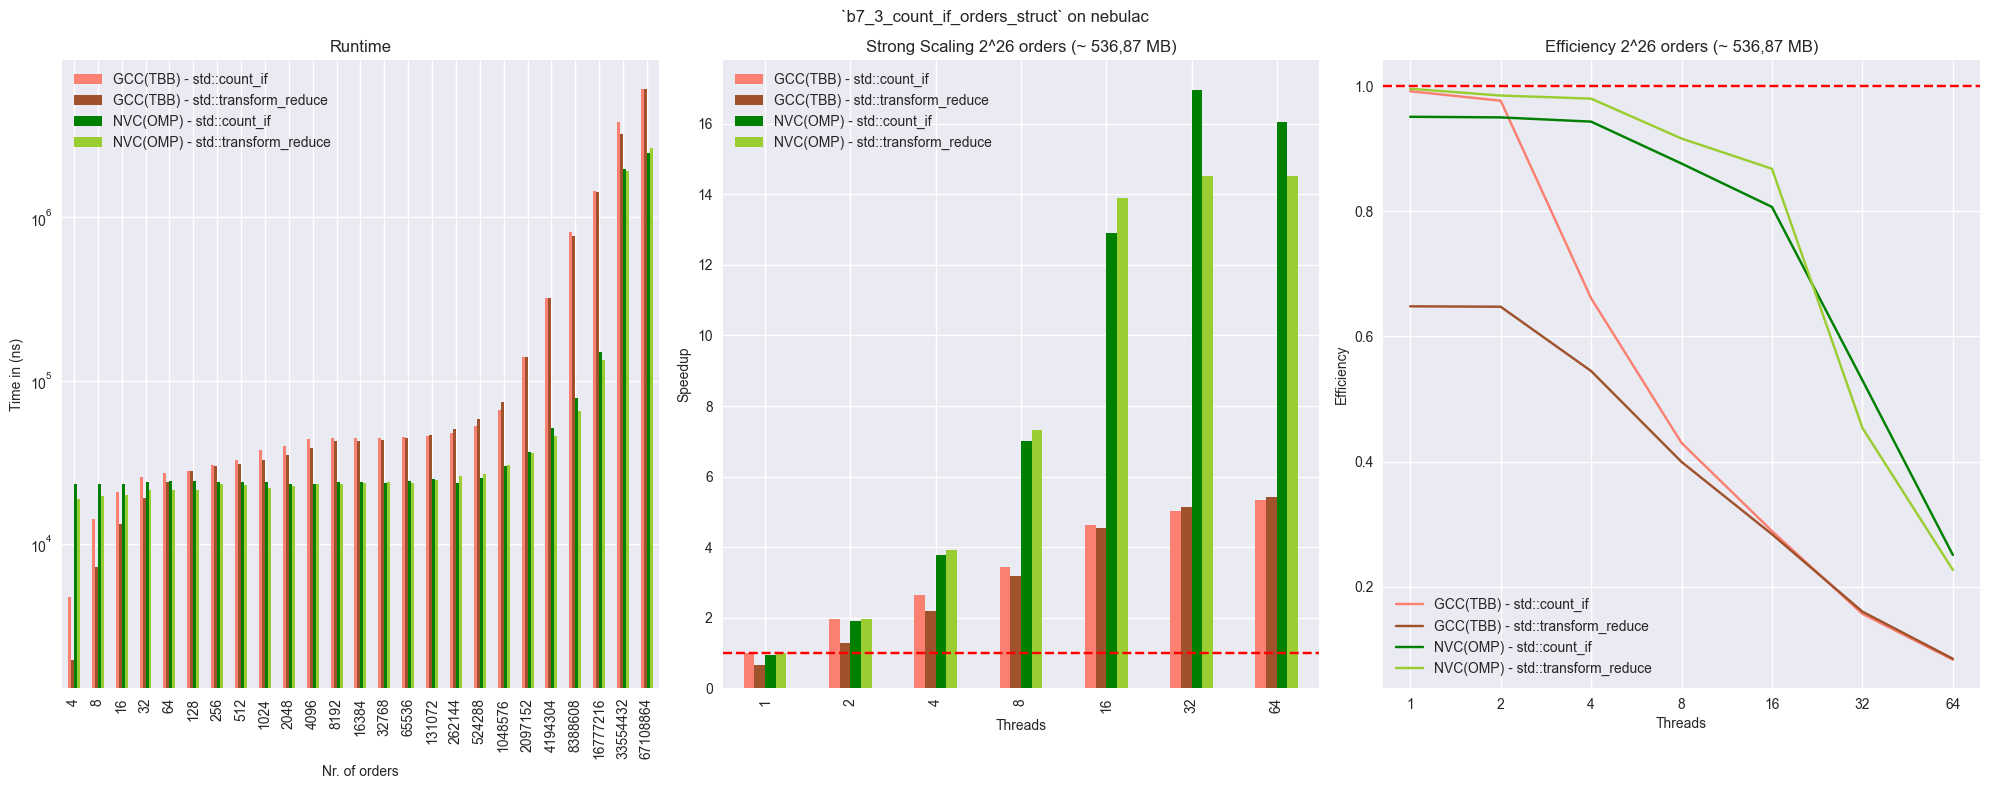

In [174]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_3_orders_struct_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of orders')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_3_orders_struct_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 orders (~ 536,87 MB)')





# plot efficiency
ax_3 = b7_3_orders_struct_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 orders (~ 536,87 MB)')


fig.suptitle(f"`b7_3_count_if_orders_struct` on {device_name}")

fig.tight_layout()

plot(f"`b7_3_count_if_orders_struct` {device_name}")

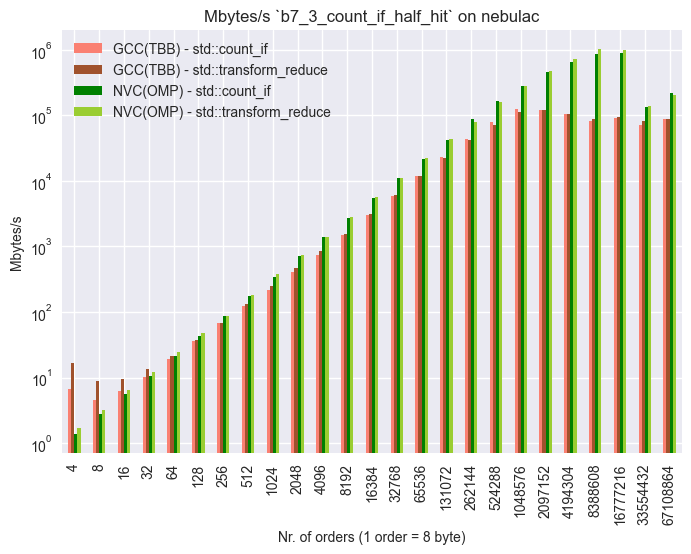

In [175]:
# mybtes graph

b7_3_orders_struct_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of orders (1 order = 8 byte)')
plt.title(f'Mbytes/s `b7_3_count_if_half_hit` on {device_name}')


plot(f'`b7_3_count_if_orders_struct` Mbytes_s on {device_name}')

## `b7_4` - stencil transform 

In [176]:
benchmark_names = [
    ("b7_4_stencil_transform_number_to_neightbours_stdev",'std::transform'),
    ("b7_4_stencil_for_each_to_neightbours_stdev",'std::for_each')
]

strong_scale_base = 'b7_4_stencil_transform_number_to_neightbours_stdev'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [177]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_4_stencil_time_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_time_merged = pd.merge(b7_4_stencil_time_merged,data[i], on='n')

b7_4_stencil_time_merged

,GCC(TBB) - std::transform,n,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,2398.03,4,2272.11,10753.3,10327.1
1,7536.15,8,7896.80,10912.4,10770.6
2,14760.60,16,19249.20,10669.9,10722.3
3,19753.90,32,23693.10,11319.4,11281.8
4,23474.60,64,26707.80,11690.7,11336.9
5,24992.20,128,28408.70,11752.9,10683.1
6,28261.10,256,29860.60,11195.4,10354.9
7,31242.80,512,33943.80,11759.3,10185.3
8,35040.70,1024,36593.00,11241.9,10636.0
9,39946.10,2048,41282.10,12078.0,11181.1


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [178]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_4_stencil_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_strong_scaling_merged = pd.merge(b7_4_stencil_strong_scaling_merged,data[i], on='threads')


b7_4_stencil_strong_scaling_merged

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,0.230703,0.216421,0.317854,0.163897
1,2,0.461195,0.432434,0.635022,0.327627
2,4,0.919441,0.863060,1.271035,0.649466
3,8,1.832599,1.721562,2.537485,1.278473
4,16,3.471429,3.346385,5.057261,2.524881
5,32,4.058381,4.039391,8.444541,4.434472
6,64,4.252808,4.244353,9.700874,7.971969


In [179]:
## efficiency graph

b7_4_stencil_efficiency = b7_4_stencil_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_4_stencil_efficiency[f'{compiler_name} - {display_name}'] = b7_4_stencil_efficiency[f'{compiler_name} - {display_name}'] / b7_4_stencil_efficiency['threads']

b7_4_stencil_efficiency

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,0.230703,0.216421,0.317854,0.163897
1,2,0.230597,0.216217,0.317511,0.163813
2,4,0.229860,0.215765,0.317759,0.162367
3,8,0.229075,0.215195,0.317186,0.159809
4,16,0.216964,0.209149,0.316079,0.157805
5,32,0.126824,0.126231,0.263892,0.138577
6,64,0.066450,0.066318,0.151576,0.124562


### Mbytes/s

In [180]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_4_stencil_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_4_stencil_bytes_merged = pd.merge(b7_4_stencil_bytes_merged,data[i], on='n')

b7_4_stencil_bytes_merged


,n,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,4,25.0206,26.4072,5.57966,5.80993
1,8,16.4540,15.7026,11.36320,11.51280
2,16,17.0725,13.0915,23.61780,23.50240
3,32,25.7165,21.4409,44.87870,45.02840
4,64,43.4511,38.1911,87.24850,89.97180
5,128,81.7856,71.9499,173.91400,191.33100
6,256,144.7920,137.0370,365.50700,395.17500
7,512,262.0770,241.2220,696.29700,803.90600
8,1024,467.4570,447.6270,1457.05000,1540.05000
9,2048,820.2050,793.6610,2712.69000,2930.30000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_12585/1698835649.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


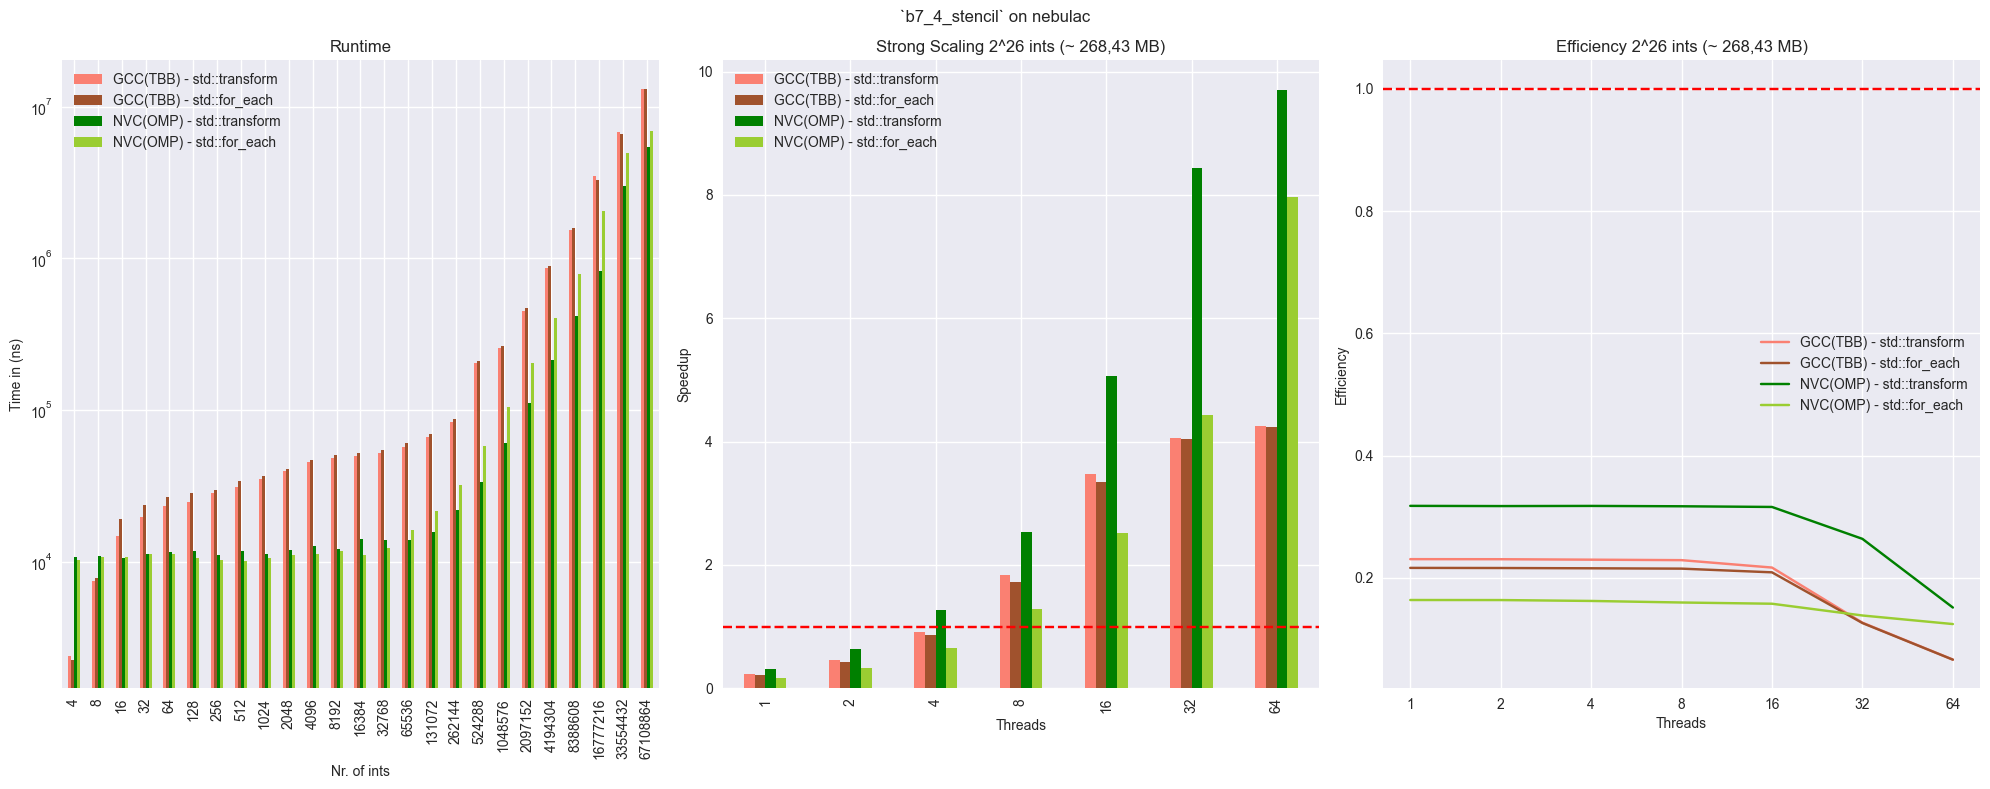

In [181]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_4_stencil_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_4_stencil_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')

#ax_2.set_ylim(0,2.5)



# plot efficiency
ax_3 = b7_4_stencil_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_4_stencil` on {device_name}")

fig.tight_layout()

plot(f"`b7_4_stencil` {device_name}")

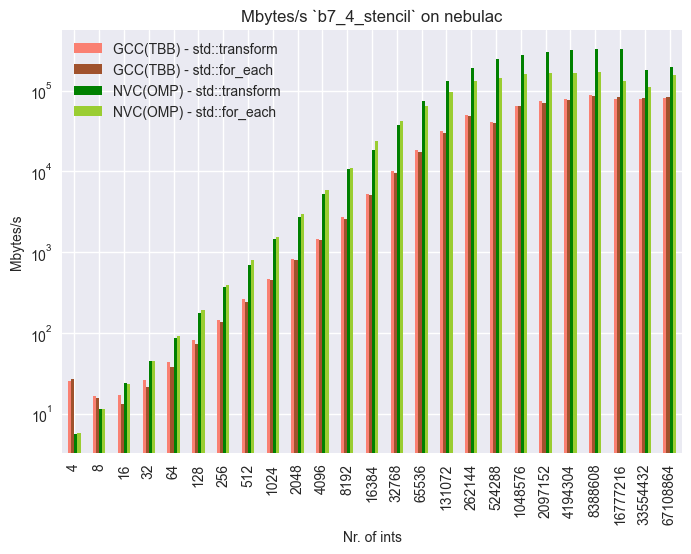

In [182]:

# mbytes graph

b7_4_stencil_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_4_stencil` on {device_name}')


plot(f'`b7_4_stencil` Mbytes_s on {device_name}')

## `b7_5` - Scalar Transform 

In [183]:
benchmark_names = [
    ("b7_5_scalar_transform_number",'std::transform'),
    ("b7_5_scalar_for_each",'std::for_each')
]

strong_scale_base = 'b7_5_scalar_transform_number'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [184]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_5_scalar_transform_time_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_time_merged = pd.merge(b7_5_scalar_transform_time_merged,data[i], on='n')

b7_5_scalar_transform_time_merged

,GCC(TBB) - std::transform,n,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,4848.41,4,4932.63,10827.8,9936.70
1,9420.06,8,9959.95,11067.4,9513.46
2,14633.30,16,16184.10,11232.9,10813.50
3,25048.70,32,20826.60,12874.8,11659.30
4,28794.60,64,24475.80,13128.0,12312.80
5,31032.70,128,26172.70,11727.3,13354.60
6,32397.60,256,29316.60,11134.6,12051.90
7,34165.50,512,31528.10,11014.7,12419.50
8,37188.70,1024,35200.40,10766.9,12559.50
9,41237.50,2048,40186.00,10838.9,11256.70


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [185]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_5_scalar_transform_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_strong_scaling_merged = pd.merge(b7_5_scalar_transform_strong_scaling_merged,data[i], on='threads')


b7_5_scalar_transform_strong_scaling_merged

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,1.013985,0.421092,0.160479,0.078646
1,2,1.999112,0.841035,0.321074,0.157209
2,4,2.965911,1.449769,0.642288,0.305323
3,8,3.368912,2.148324,1.278729,0.666268
4,16,4.262211,2.965484,2.555275,1.206038
5,32,4.515062,3.299656,4.335920,2.038000
6,64,4.613108,3.344168,8.509405,4.270277


In [186]:
## efficiency graph

b7_5_scalar_transform_efficiency = b7_5_scalar_transform_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_5_scalar_transform_efficiency[f'{compiler_name} - {display_name}'] = b7_5_scalar_transform_efficiency[f'{compiler_name} - {display_name}'] / b7_5_scalar_transform_efficiency['threads']

b7_5_scalar_transform_efficiency

,threads,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,1,1.013985,0.421092,0.160479,0.078646
1,2,0.999556,0.420518,0.160537,0.078604
2,4,0.741478,0.362442,0.160572,0.076331
3,8,0.421114,0.268540,0.159841,0.083284
4,16,0.266388,0.185343,0.159705,0.075377
5,32,0.141096,0.103114,0.135498,0.063687
6,64,0.072080,0.052253,0.132959,0.066723


### Mbytes/s

In [187]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_5_scalar_transform_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_5_scalar_transform_bytes_merged = pd.merge(b7_5_scalar_transform_bytes_merged,data[i], on='n')

b7_5_scalar_transform_bytes_merged

,n,GCC(TBB) - std::transform,GCC(TBB) - std::for_each,NVC(OMP) - std::transform,NVC(OMP) - std::for_each
0,4,6.60011,6.48740,2.95535,3.22039
1,8,6.79402,6.42574,5.78273,6.72731
2,16,8.74716,7.90901,11.39510,11.83710
3,32,10.22010,12.29200,19.88380,21.95670
4,64,17.78110,20.91860,39.00070,41.58290
5,128,32.99740,39.12480,87.31790,76.67780
6,256,63.21450,69.85790,183.93100,169.93100
7,512,119.88700,129.91600,371.86800,329.80500
8,1024,220.28200,232.72500,760.85400,652.25700
9,2048,397.30800,407.70500,1511.59000,1455.48000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_12585/3247401511.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


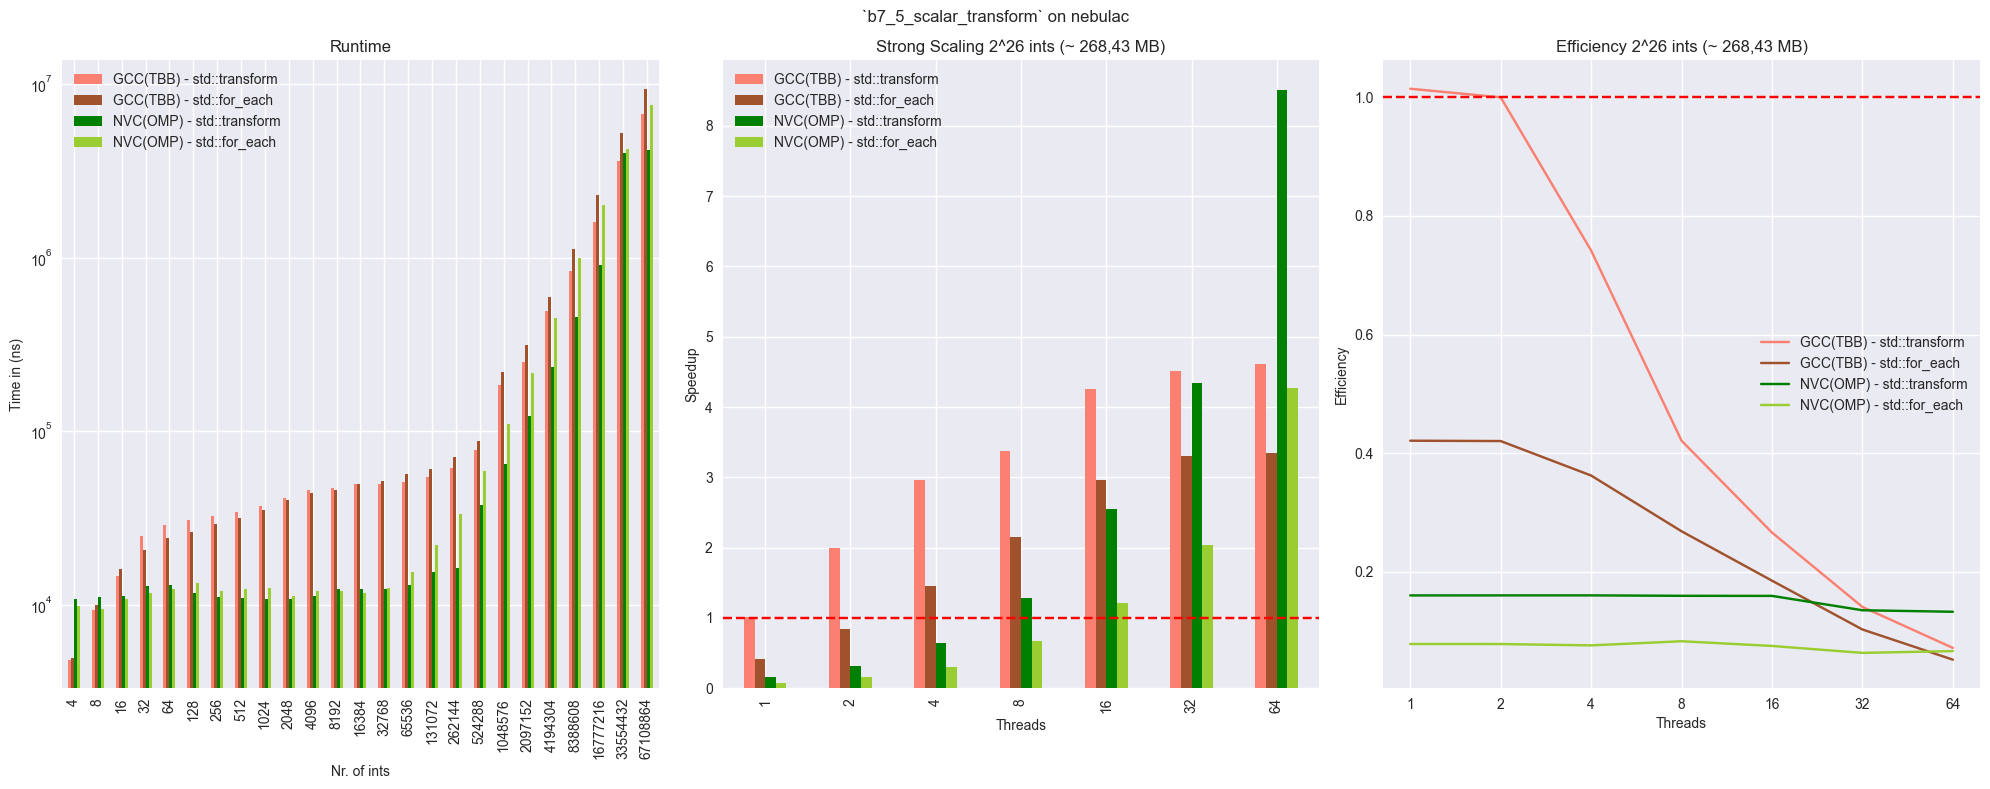

In [188]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_5_scalar_transform_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_5_scalar_transform_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')




# plot efficiency
ax_3 = b7_5_scalar_transform_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_5_scalar_transform` on {device_name}")

fig.tight_layout()

plot(f"`b7_5_scalar_transform` {device_name}")

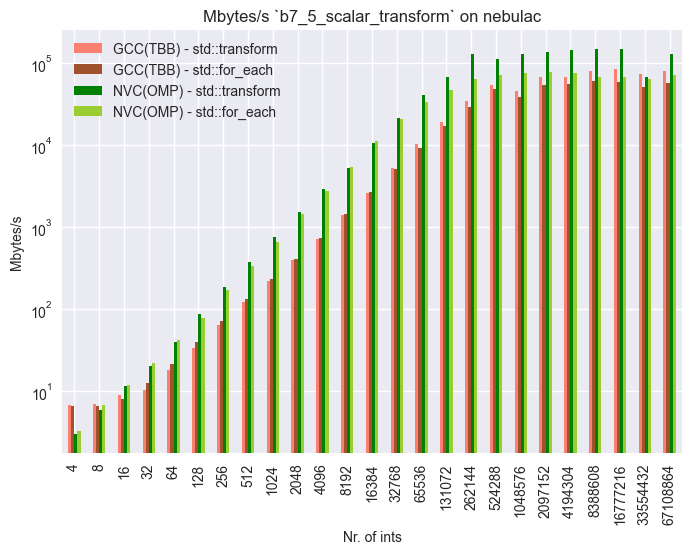

In [189]:

# mbytes graph

b7_5_scalar_transform_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_5_scalar_transform` on {device_name}')


plot(f'`b7_5_scalar_transform` Mbytes_s on {device_name}')

## `b7_6` - Serial vs direct call

In [190]:
benchmark_names = [
    ("b7_6_transform_reduce",'std::transform_reduce'),
    ("b7_6_serial_transform_reduce",'serial')
]

strong_scale_base = 'b7_6_transform_reduce'

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison -

Check how the runtime without constraining the threads develops with increasing input size

In [191]:
# collect data for instances
data = [
    par_data_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name 
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]

# merge for plotting
b7_6_transform_reduce_vs_serial_time_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_time_merged = pd.merge(b7_6_transform_reduce_vs_serial_time_merged,data[i], on='n')

b7_6_transform_reduce_vs_serial_time_merged

,GCC(TBB) - std::transform_reduce,n,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,2342.22,4,7683.86,22624.3,28868.9
1,7278.82,8,15171.50,23234.9,28092.6
2,13131.10,16,25027.70,24308.9,29618.9
3,18812.90,32,37962.40,24960.4,32176.7
4,23843.70,64,46032.20,26399.2,33259.1
5,27486.60,128,50922.20,25712.8,32862.8
6,29718.20,256,54499.90,26550.3,35000.6
7,30663.60,512,61041.10,27135.6,36223.4
8,31488.40,1024,68386.00,27667.4,37870.2
9,35154.20,2048,78886.70,25194.7,40249.7


### Strong Scaling -
 
2^26 fixed input size with threads 1-64

In [192]:
# collect data for instances
data = [
    get_strong_scaling_algo(compiler_location=comp_location, 
                  compiler_name=f'{comp_name} - {display_name}', 
                  bench_name=bench_name ,
                  base_of=strong_scale_base
    ) 
    for comp_location, comp_name in instances 
    for bench_name, display_name in benchmark_names 
]


# merge for plotting
b7_6_transform_reduce_vs_serial_strong_scaling_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_strong_scaling_merged = pd.merge(b7_6_transform_reduce_vs_serial_strong_scaling_merged,data[i], on='threads')


b7_6_transform_reduce_vs_serial_strong_scaling_merged

,threads,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,1,0.998353,0.474833,0.787843,0.229085
1,2,1.982206,0.612633,1.579317,0.400501
2,4,2.790081,0.738214,3.135636,0.589340
3,8,3.816272,0.585947,6.133391,0.512221
4,16,5.271062,0.650189,11.960616,0.542156
5,32,5.831836,0.630397,16.143634,0.549718
6,64,6.242587,0.600515,13.858381,0.493765


In [193]:
## efficiency graph

b7_6_transform_reduce_vs_serial_efficiency = b7_6_transform_reduce_vs_serial_strong_scaling_merged.copy()

for _,compiler_name in instances:
    for bench_name, display_name in benchmark_names:
        b7_6_transform_reduce_vs_serial_efficiency[f'{compiler_name} - {display_name}'] = b7_6_transform_reduce_vs_serial_efficiency[f'{compiler_name} - {display_name}'] / b7_6_transform_reduce_vs_serial_efficiency['threads']

b7_6_transform_reduce_vs_serial_efficiency

,threads,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,1,0.998353,0.474833,0.787843,0.229085
1,2,0.991103,0.306317,0.789658,0.200250
2,4,0.697520,0.184553,0.783909,0.147335
3,8,0.477034,0.073243,0.766674,0.064028
4,16,0.329441,0.040637,0.747539,0.033885
5,32,0.182245,0.019700,0.504489,0.017179
6,64,0.097540,0.009383,0.216537,0.007715


### Mbytes/s   

In [194]:

# collect data for instances
data = [
    bytes_per_second_data_algo(compiler_location=comp_location,
                               compiler_name=f'{comp_name} - {display_name}',
                               benchmark_name=bench_name
                               )
    for comp_location, comp_name in instances
    for bench_name, display_name in benchmark_names
]

# merge for plotting
b7_6_transform_reduce_vs_serial_bytes_merged = data[0]

for i in range(1,len(data)):
    b7_6_transform_reduce_vs_serial_bytes_merged = pd.merge(b7_6_transform_reduce_vs_serial_bytes_merged,data[i], on='n')

b7_6_transform_reduce_vs_serial_bytes_merged

,n,GCC(TBB) - std::transform_reduce,GCC(TBB) - serial,NVC(OMP) - std::transform_reduce,NVC(OMP) - serial
0,4,13.66220,12.4937,1.41441,3.32538
1,8,8.79263,12.6553,2.75448,6.83455
2,16,9.74783,15.3430,5.26555,12.96470
3,32,13.60770,20.2305,10.25620,23.86820
4,64,21.47320,33.3679,19.39450,46.18280
5,128,37.25450,60.3274,39.82460,93.47950
6,256,68.91390,112.7340,77.13650,175.54000
7,512,133.57900,201.3070,150.94600,339.22900
8,1024,260.15900,359.3720,296.08800,648.95300
9,2048,466.06200,623.0710,650.29500,1221.18000


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_12585/182734503.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


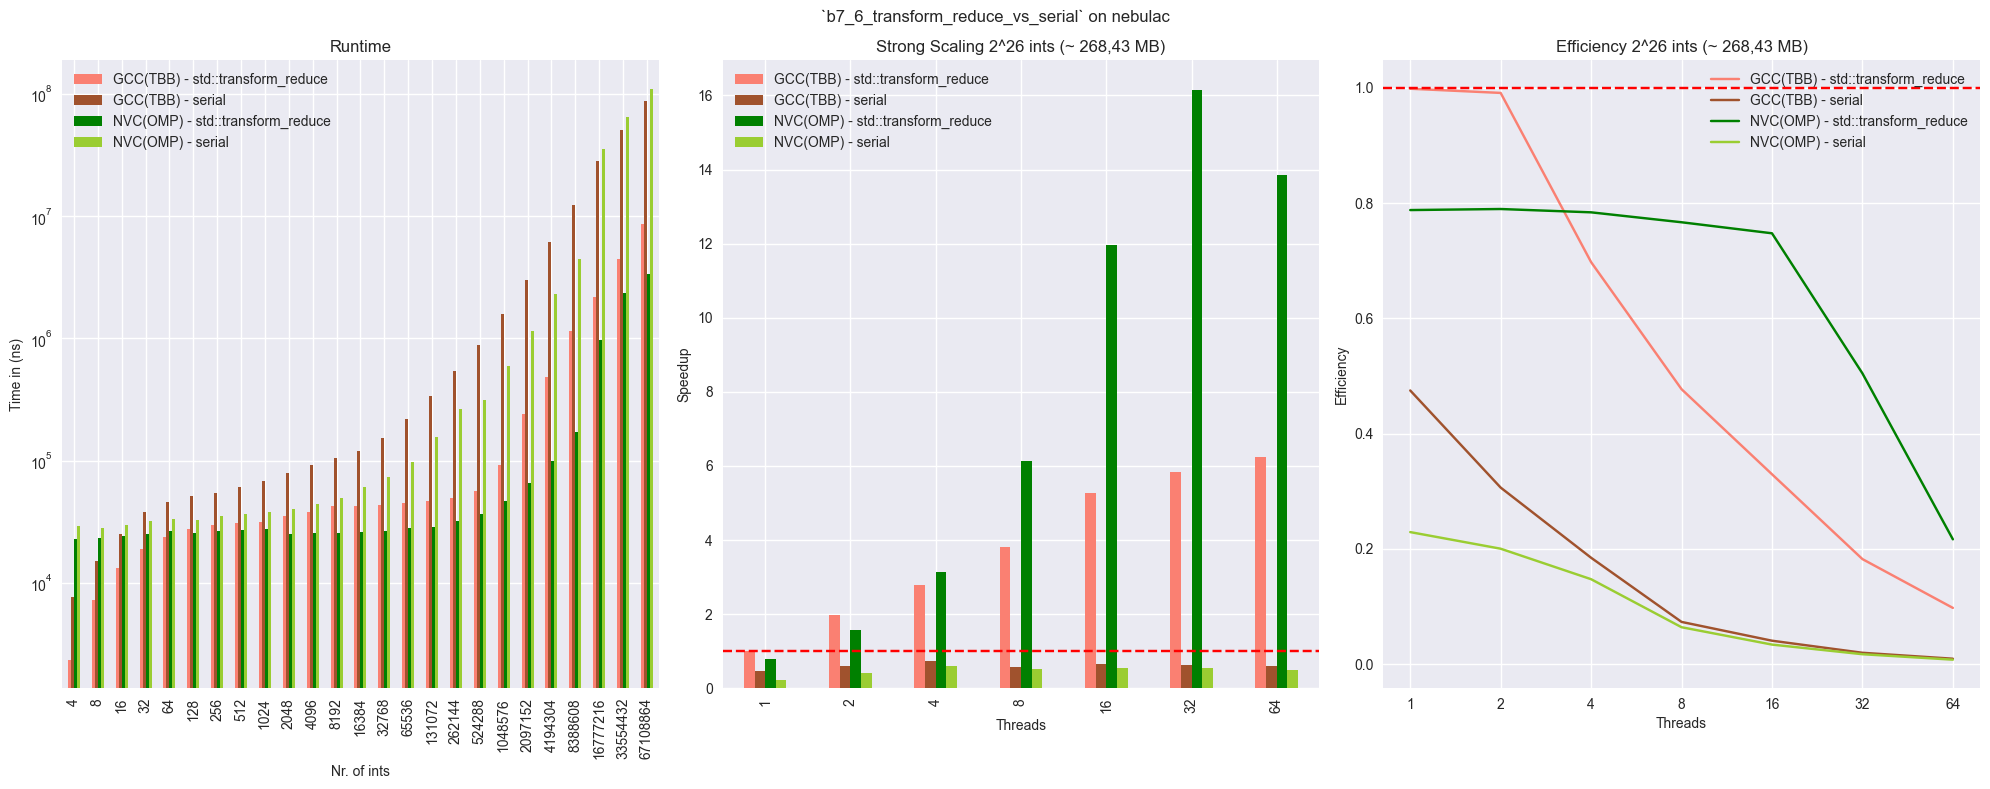

In [195]:
# graphs 

colorArray =[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))


# plot runtime
ax_1 = b7_6_transform_reduce_vs_serial_time_merged.plot(kind='bar',x='n',align='center',color=colorArray, ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=10)


# plot strong scaling
ax_2 = b7_6_transform_reduce_vs_serial_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=colorArray,
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')





# plot efficiency
ax_3 = b7_6_transform_reduce_vs_serial_efficiency.plot(x='threads',
                                                            color=colorArray,
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b7_6_transform_reduce_vs_serial` on {device_name}")

fig.tight_layout()

plot(f"`b7_6_transform_reduce_vs_serial` {device_name}")

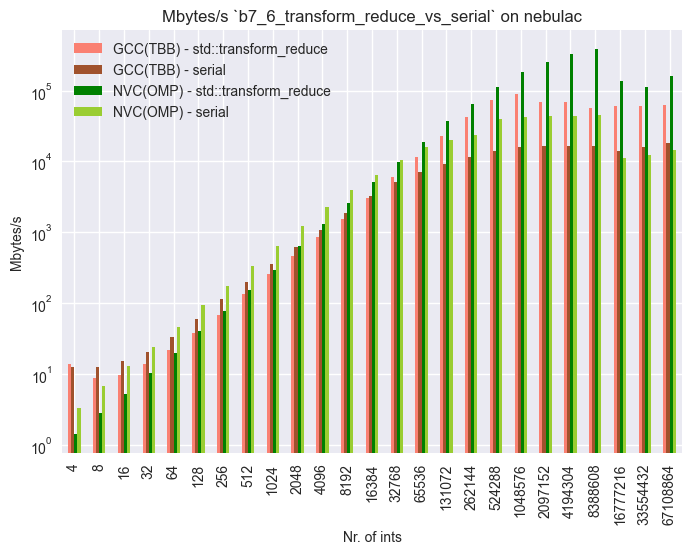

In [196]:
# mbytes graph

b7_6_transform_reduce_vs_serial_bytes_merged.plot(kind='bar',
                       x='n',
                       color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_OMP_COLOR,NVC_OMP_COLOR_SECONDARY]
                       )

plt.yscale('log',base=10)
plt.ylabel('Mbytes/s')
plt.xlabel('Nr. of ints')
plt.title(f'Mbytes/s `b7_6_transform_reduce_vs_serial` on {device_name}')


plot(f'`b7_6_transform_reduce_vs_serial` Mbytes_s on {device_name}')

######################## DIVIDER ########################

## Performance Portability Calculation (Inter Compiler)

Runtime

In [197]:
# calc pp_metrics

def calc_pp(data_points:List[int]) -> int:
    min_val = min(data_points)
    return len(data_points) / sum([1/(min_val/val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('b7_1_copy',b7_1_time_merged, [' - std::copy', ' - std::foreach']),
    
    ('b7_2_all_of_all_true',b7_2_time_merged, [' - std::all_of', ' - std::transform_reduce']),
    ('b7_2_all_of_first_false',b7_2_first_false_time_merged, [' - std::all_of', ' - std::transform_reduce']),
    ('b7_2_all_of_last_false',b7_2_last_false_time_merged, [' - std::all_of', ' - std::transform_reduce']),
    ('b7_2_all_of_auto_false',b7_2_auto_false_time_merged, [' - std::all_of', ' - std::transform_reduce']),


    ('b7_3_count_if_all_hit',b7_3_all_hit_time_merged, [' - std::count_if', ' - std::transform_reduce']),
    ('b7_3_count_if_half_hit',b7_3_half_hit_time_merged, [' - std::count_if', ' - std::transform_reduce']),
    ('b7_3_count_if_orders_struct',b7_3_orders_struct_time_merged, [' - std::count_if', ' - std::transform_reduce']),

    
    ('b7_4_stencil_transform',b7_4_stencil_time_merged, [' - std::transform', ' - std::for_each']),


    ('b7_5_scalar_transform',b7_5_scalar_transform_time_merged, [' - std::transform', ' - std::for_each']),


    ('b7_6_transform_reduce',b7_6_transform_reduce_vs_serial_time_merged, [' - std::transform_reduce', ' - serial']),
]


for root_display_name, data_source, suffixes in data_fields:

    for suffix in suffixes:
        entry_dict = {
            'name': [root_display_name + suffix],
        }

        vals = []

        # getting the data from the source for each compiler
        for comp in compilers:
            current_val = int(data_source.iloc[-1][comp + suffix])
            entry_dict[comp] = [current_val]

            vals.append(current_val)

        entry_dict['PP'] = calc_pp(vals)

        other_df = pd.DataFrame.from_dict(entry_dict)
        pp_df = pd.concat([pp_df,other_df],ignore_index=True)



pp_df['Percentage'] = pp_df['PP']

pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')


pp_df_styled = pp_df.style.format({'Percentage': "{:.2%}"})
pp_df_styled

,name,GCC(TBB),NVC(OMP),PP,Percentage,INTERPRET
0,b7_1_copy - std::copy,6947240,7111280,0.988332,98.83%,GOOD
1,b7_1_copy - std::foreach,9768800,7159410,0.845856,84.59%,BAD
2,b7_2_all_of_all_true - std::all_of,2928910,10794300,0.426855,42.69%,BAD
3,b7_2_all_of_all_true - std::transform_reduce,3009280,1894840,0.772754,77.28%,BAD
4,b7_2_all_of_first_false - std::all_of,27892,70915,0.564575,56.46%,BAD
5,b7_2_all_of_first_false - std::transform_reduce,3004610,1717190,0.727346,72.73%,BAD
6,b7_2_all_of_last_false - std::all_of,2540890,10293300,0.395956,39.60%,BAD
7,b7_2_all_of_last_false - std::transform_reduce,2974700,1701000,0.727592,72.76%,BAD
8,b7_2_all_of_auto_false - std::all_of,18657,54453,0.510382,51.04%,BAD
9,b7_2_all_of_auto_false - std::transform_reduce,187593,26168,0.244834,24.48%,BAD


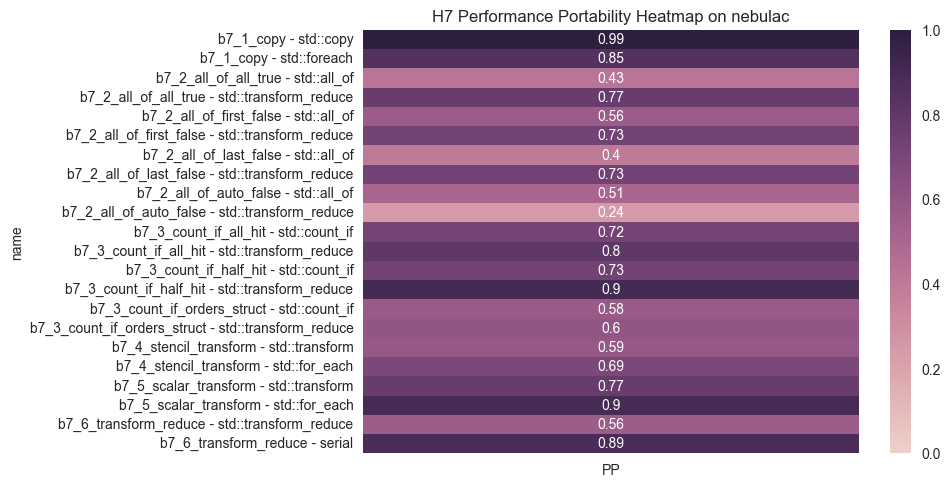

In [198]:
import seaborn as sns

heatmap_pp_df = pp_df.copy()
heatmap_pp_df = heatmap_pp_df.drop(columns=['GCC(TBB)','NVC(OMP)','Percentage','INTERPRET'])
heatmap_pp_df = heatmap_pp_df.set_index(['name'])


sns.heatmap(heatmap_pp_df, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1)

plt.title(f'H7 Performance Portability Heatmap on {device_name}')

plot(f'H7 Performance Portability Heatmap on {device_name}')

## Findings for H7

### XXX

### General


### GPU Findings


### Hypothesis Findings


